Import libraries and define main constants

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

TOP_UNIVERSITIES_BASE_URL = "https://www.topuniversities.com"
TOP_UNIVERSITIES_RANKING_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"
TOP_UNIVERSITIES_DETAILS_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt"
TIMES_RANKING_URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
# Max rank to load for each ranking
MAX_RANK = 200

# Hunting in the data jungle

In this first part, we will load the data from both Top Universities and Times Higher Education into a data frame using a normalized format. This will allow us to do further analysis more easily.

For each university, we will follow the following steps:
- Fetch data from the website
- First exploration of available data
- Read the data: convert the raw values fetched from the websites into proper floats and integers
- Create normalized entries and build a data frame
- Compute derived values

## Cache layer

The following method adds a cache for simple HTTP GET requests and ensures that at most one request will be sent per unique URL.

**Re-evalute the cell with the function to flush the cache.**

In [2]:
CACHE = {}
def cached_get_request(url, cache=CACHE):
    """
    Perform a cached HTTP GET request for `url`.
    
    The first time you send a request for an `url`, it will effectivelly
    send an HTTP request. The response will be cached in `cache` and each
    subsequent call for a cached URL will use a cache lookup using an exact
    match on the url instead of sending a new HTTP request.
    
    This function will use a shared cache by default, you can provide your
    own dictionary if you want to override this behavior.
    Reevalute this function to flush the shared cache.
    
    :param str url: URL to GET
    :cache: A dictionary from urls to HTTP responses. Mutated if it did not contain the key `url`.
    :return: _requests_' response for the provided URL.
    """
    
    if url not in cache:
        cache[url] = requests.get(url)
    return cache[url]

## Fetching data from Top Universities

- [General ranking](https://www.topuniversities.com/university-rankings/world-university-rankings/2018#ranking-tab)
- [Ranking indicators](https://www.topuniversities.com/university-rankings/world-university-rankings/2018#indicator-tab)

We assume that the order of the universities in both tabs is the same.

Before properly fetching the data, we define a function to convert the string representation of the ranks to integers.
This will allow us to filter the  universities using their ranking and avoid unnecessary requests for pages detailing
universities beyond the rank we are interested in.

In [3]:
def read_rank(raw_rank):
    """
    Read a raw rank string into an integer.
    
    It works for ranks from either Top Universities or Times Higher Education.
    In case of ranges, it returns the best (lowest) bound.
    
        >>> read_rank("10")
        10
        >>> read_rank("15-20")
        15
        >>> read_rank("23–77")
        23
        >>> read_rank("=5")
        5
        >>> read_rank("1000+")
        1000
    
    :param str raw_rank: Rank string, as found by scrapping
    :rtype: int
    :return: Integer representing the rank of the university
    """
    if '-' in raw_rank:
        return int(raw_rank[:raw_rank.index('-')])
    if '–' in raw_rank:
        return int(raw_rank[:raw_rank.index('–')])
    return int(raw_rank.replace('=', '').replace('+', ''))

In [4]:
def get_raw_top_universities_ranking(max_rank):
    """
    Load raw ranking data from the Top Universities website.
    
    This function fetches the general ranking, the ranking indicators
    and for each returned universities its details page.
    This function yields a (general, indicators, details) tuple for
    each entry with its rank ≤ max_rank. The entries are returned in the
    order of website, we assume that it is already sorted by ranking.
    - `general` is the JSON document for the entry in the general ranking
    - `indicators` is the JSON document for the entry in the ranking indicators for the university
    - `details` is the parsed HTML documents for the details page of the university
    
    :param int max_rank: Inclusive maximum rank to accept.
    :return: A generator for (general, indicators, details) tuples
    """
    
    # Fetch the general ranking
    ranking_response = cached_get_request(TOP_UNIVERSITIES_RANKING_URL)
    raw_ranking_data = ranking_response.json()["data"]
    # Fetch the ranking indicators
    ranking_indicators_response = cached_get_request(TOP_UNIVERSITIES_DETAILS_URL)
    raw_ranking_indicators_data = ranking_indicators_response.json()['data']
    # Assume that both the ranking and indicators have the same order
    for general, indicators in zip(raw_ranking_data, raw_ranking_indicators_data):
        if read_rank(general["rank_display"]) > max_rank:
            # Skip entries ranked worse than `max_rank`.
            # For sorted entries an early exit using a `break` would be enough
            # It seems that the data is sorted but since we don't control it, we
            # simply keep a `continue`.
            continue
        
        # Build the URL for the details page and fetch it.
        details_reponse = cached_get_request(TOP_UNIVERSITIES_BASE_URL + general["url"])
        details = BeautifulSoup(details_reponse.text, 'html.parser')
        yield (general, indicators, details)

We'll now load the raw (without any processing) data for the best Top Universities entries.

In [5]:
# We are loading the universities eagerly so we can then show its values.
# It would be better to keep the generator if there are memory constraints.
raw_top_universities = [*get_raw_top_universities_ranking(MAX_RANK)]

## Fetching data from Times Higher Education

[Ranking](https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json)

In [6]:
def get_raw_times_ranking(max_rank):
    """
    Load raw ranking data from the Top Universities website.
    
    This function fetches the general ranking and filters
    the entries by rank to exclude those above max_rank.
    
    :param int max_rank: Inclusive maximum rank to accept.
    :return: A generator for raw entries with rank ≤ max_rank
    """
    
    # Fetch the general ranking
    ranking_response = cached_get_request(TIMES_RANKING_URL)
    for entry in ranking_response.json()["data"]:
        if read_rank(entry["rank"]) > max_rank:
            # Skip entries ranked worse than `max_rank`.
            # For sorted entries an early exit using a `break` would be enough
            # It seems that the data is sorted but since we don't control it, we
            # simply keep a `continue`.
            continue
        yield entry

In [7]:
# We are loading the universities eagerly so we can then show its values.
# It would be better to keep the generator if there are memory constraints.
raw_times = [*get_raw_times_ranking(MAX_RANK)]

## Top Universities exploration

Let's check how many entries we have:

In [8]:
len(raw_top_universities)

199

We found only 199 universities satisfying `rank ≤ 200`: one university is missing.

In [9]:
# Display the position in the ranking and the displayed value of the rank
pd.DataFrame(
    [{"raw_rank": general["rank_display"]} for idx, (general, _, _) in enumerate(raw_top_universities)],
    range(1, 1 + len(raw_top_universities))
)

,raw_rank
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9
10,10


We see that the missing value is at the position 198: its rank is 199 instead of 198.
We have three universities with the rank 195, the ones in the three positions 195, 196 and 197. We expect the next rank to be 198 but get 199.
This is a minor issue at the end of the ranking so we decide to ignore it and keep the 199 entries we already have.

Lets now take a closer look at what kind of data is available for each entry. Recall that each entry is a tuple with the general data available on the main ranking, indicator scores and the parsed details page.

We'll use the data for the first university since all the universities follow the same format.

In [10]:
# General data
raw_top_universities[0][0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

We get a relatively clean JSON document. Here is the description of its fields:

- `title`: Name of the university
- `rank_display`: Rank string used for the view of the ranking
- `score`: Score assigned to the university and used for the ranking. In the inclusive range [0, 100]
- `url`: Absolute path to the details page for the university (the origin is `https://www.topuniversities.com`)
- `country`: Country name
- `cc`: Country code
- `region`: Region name. Each region represents a group of countries (a region is the intermediate level between the country and the continent)
- `stars`: The number of stars to display for this university
- `core_id`: Some ID identifying the university
- `nid`: Another ID
- `guide`: The HTML source for the link to the guide page for this country or region
- `logo`: The HTML source for the image tag for the logo of the university

In [11]:
# Indicators
raw_top_universities[0][1]

{'2971069': '<div class="td-wrap"><div class="td-wrap-in">100</div></div>',
 '2971069_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 100%;"></span><span class="rank ">6</span></div></div></div>',
 '2971070': '<div class="td-wrap"><div class="td-wrap-in">99.9</div></div>',
 '2971070_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 99.9%;"></span><span class="rank ">8</span></div></div></div>',
 '2971071': '<div class="td-wrap"><div class="td-wrap-in">100</div></div>',
 '2971071_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 100%;"></span><span class="rank ">4</span></div></div></div>',
 '2971072': '<div class="td-wrap"><div class="td-wrap-in">100</div></div>',
 '2971072_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 100%;"></span><span class="rank ">14</span></div>

The JSON document of indicators ranking is much more noisy.

Its keys are numerical IDs for indicators. Here is a conversion table for the indicators we are interested in:

| Key     | Name                   |
|---------|------------------------|
| overall | Overall score          |
| 2971069 | Academic reputation    |
| 2971070 | Citations per faculty  |
| 2971071 | Employer reputation    |
| 2971072 | Faculty students       |
| 2971073 | International faculty  |
| 2971074 | International students |

Most of the values are HTML fragments embedding percentages or ranks for the percentages.
The remaining fields are `stars`, `region` and `uni`, they are redudant with the general data.

Some values are missing for some universities, for example see Kyoto. It does not have the International faculty (2971073) or Internation students (2971074) fields.

In [12]:
raw_top_universities[35][1]

{'2971069': '<div class="td-wrap"><div class="td-wrap-in">99.7</div></div>',
 '2971069_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 99.7%;"></span><span class="rank ">18</span></div></div></div>',
 '2971070': '<div class="td-wrap"><div class="td-wrap-in">56.4</div></div>',
 '2971070_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 56.4%;"></span><span class="rank ">185</span></div></div></div>',
 '2971071': '<div class="td-wrap"><div class="td-wrap-in">94.9</div></div>',
 '2971071_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 94.9%;"></span><span class="rank ">47</span></div></div></div>',
 '2971072': '<div class="td-wrap"><div class="td-wrap-in">95.7</div></div>',
 '2971072_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 95.7%;"></span><span class="rank ">54</s

### Details

We won't print the detals page because it's harder to display. In this case, it corresponds to the parsed HTML of [this details page for the MIT](https://www.topuniversities.com/universities/massachusetts-institute-technology-mit). You can simply look at the page (and eventually inspect it) to know what's available.

Here are some values of the details page that we are interested in: faculty staf (total & international) and students (total & international).

These values can be found in the charts below the star ratings.

We also notice that these values are missing for the [New York University](https://www.topuniversities.com/universities/new-york-university-nyu/new-york-university-nyu#wurs), we'll have to use NaN there.

## Times Higher Education exploration

Let's check how many entries we fetched for Times Higher Eduction:

In [13]:
len(raw_times)

200

Excellent, we had 200 entries as we wanted. We can take a look at what data is available:

In [14]:
raw_times[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

This data is of higher quality than for Top Universities. We have already all the data we need for our analysis, except for the region name so we'll have to deal with it.

Here is the detail of the data we are interested in:
- `name`: Name of the university
- `rank`: General rank
- `location`: Country
- `stats_number_students`: Total number of students
- `stats_pc_intl_students`: Percentage of international students
- `stats_student_staff_ratio`: Students per faculty staff members (inverse of what we want)
- `scores_citation`: Indicator for citations, we keep it to compare it the citations indicators of Top Universities
- `scores_overall`, `scores_international_outlook`: Other indicators that we can compare


## Read data

Now that we know what is available from which website, we'll properly read the data. We will convert the raw results we fetched:
- Apply the necessary type conversion, mainly parsing the numeric values
- Create a single document with normalized names (the same name for the same value, independent of the source website)
- Create a single data frame containing all of these data

The normalized entries we want will have the following interface:
- `name: str`: Name of the university
- `rank: int`: Rank of this university (best rank in case the source used a range). The rank is not unique
- `coutry: str`: Name of the country for this university
- `region: str`: Name of the continent for this university
- `faculty_total: int`: Total number of faculty staff
- `students_total: int`: Total number of students

In [15]:
def make_entry(name, rank, country, region, faculty_total, students_total, students_international, **extra_keys):
    """
    Create a dictionary representing a normalized ranking entry
    """
    return {
        "name": name,
        "rank": rank,
        "country": country,
        "region": region,
        "faculty_total": faculty_total,
        "students_total": students_total,
        "students_international": students_international,
        **extra_keys
    }

To read the different fields, we use the following helper functions:

- `read_rank` allows to convert a string of the form `"=40"` to `40`, `"10-12"` to `10`, `"23–77"` to `23`. This function was defined above, before the function to fetch data from the server.

- `read_us_formatted_integer` allows to convert string representation with a comma used used as the thousands separtor.

- `read_percentage` converts a percentage string (with or without the `%` sign) to a ration on the inclusive [0, 1] range

In [16]:
def read_us_formatted_integer(raw_integer):
    """
    Reads a string representing an integer properly formatted using US convention.
    
    The US format uses commas as the thousands separator.
    
    Examples:

        >>> read_us_formatted_integer("0")
        0
        >>> read_us_formatted_integer("1,000")
        1000
        >>> read_us_formatted_integer("999,999,999")
        999999999
    
    ```
    :param str raw_integer: US Formatted string for an integer
    :rtype: int
    :return: Integer corresponding to the provided value.
    """
    return int(raw_integer.replace(",", ""))

In [17]:
def read_percentage(raw_percentage):
    """
    Reads a percentage string into a ratio in [0, 1].
    
    Works with or without the percent sign.
    
    :param raw_percentage str: Percentage string
    :return float: Ratio corresponding to the percentage (between 0 and 1)
    """ 
    return float(raw_percentage.replace("%", "")) / 100

We will finally define some utility functions to scrap the HTML and build the normalized documents

In [18]:
def scrap_top_universities_details_number(details_node, class_name):
    """
    Scrap a details page from Top Universities to get the content of "div.${class_name} div.number"
    
    Returns None if no content is found.
    
    :param details_node: Node of HTML document for the details page
    :param str class_name: Class name used to select the content
    :rtype: Union[str, None]
    :return: The text content of the matched node, or None if the node is not found
    """
    try:
        value_inside = details_node.find("div", {"class": class_name}).find("div", {"class": "number"}).text.strip()
    except Exception as e:
        return None
    return value_inside

In [19]:
def read_top_universities_indicators(raw_indicators):
    """
    Read the "overall", "citations", "international_faculty" and "internation_students" indicators.
    
    TODO: international score
    and custom international score for  specific university
    Note that the international_score is mean of international faculty score and international_students score
    as explained in part 5
    
    :param raw_indicators: JSON values of one university
    :rtype: Tuple[float, float, float, float]
    :return: A tuple (overall, citations, internation_faculty, international_students)
    """
    # Mapping of the indicators we are interested in, from their name to their ID
    NAME_TO_INDICATOR_ID = {
        "citations": "2971070",
        "international_faculty": "2971073",
        "international_students": "2971074",
    }
    
    def read_indicator(raw_indicators, key):
        """
        Read a Top Universities indicator as a ratio between 0 and 1
        
        It tries to read the indicator with the key `key` from `raw_indicators`.
        The values are usually HTML fragments containing a percentage. Here is an exemple:
        
        ```
        <div class=\"td-wrap\"><div class=\"td-wrap-in\">99.9</div></div>
        ```
        
        If the key is not found or the fragment malformed, returns None.
        
        :param str raw_indicators: Document containing the indicators for a university
        :param str key: Key 
        :param rtype: Union[float, None]
        :param return: A float representing the value of the indicator as a ration in [0, 1]
        """
        if key not in raw_indicators:
            return None
        document = BeautifulSoup(raw_indicators[key], 'html.parser')
        try:
            return read_percentage(document.find("div", {"class": "td-wrap-in"}).text.strip())
        except Exception as e:
            return None
    
    overall = read_indicator(raw_indicators, "overall")
    citations = read_indicator(raw_indicators, NAME_TO_INDICATOR_ID["citations"])
    international_faculty = read_indicator(raw_indicators, NAME_TO_INDICATOR_ID["international_faculty"])
    international_students = read_indicator(raw_indicators, NAME_TO_INDICATOR_ID["international_students"])

    return (overall, citations, international_faculty, international_students)

def read_top_universities_entry(general, indicators, details):
    """
    Normalize a single Top Universities entry
    
    :param general: Raw JSON document representing the data from the general ranking
    :param indicators: Raw JSON document representing the data from the indicators rankings
    :param international_score: Parsed HTML of the details page
    :returns: Normalized entry, as produced by `make_entry`
    """
    
    # Read general data
    name = general["title"]
    rank = read_rank(general["rank_display"])
    country = general["country"]
    region = general["region"]

    # Read indicators
    (overall, citations, international_faculty, international_students) = read_top_universities_indicators(indicators)
    
    # Read details
    faculty_total_str = scrap_top_universities_details_number(details, "total faculty")
    faculty_international_str = scrap_top_universities_details_number(details, "inter faculty")
    students_total_str  = scrap_top_universities_details_number(details, "total student")
    students_international_str  = scrap_top_universities_details_number(details, "total inter")
    
    # Helper to safely map a US-formatted integer to its value if it is defined
    def read_optional_us_integer(str_or_none):
        return read_us_formatted_integer(str_or_none) if str_or_none is not None else None
    
    faculty_total = read_optional_us_integer(faculty_total_str)
    faculty_international = read_optional_us_integer(faculty_international_str) 
    students_total = read_optional_us_integer(students_total_str) 
    students_international = read_optional_us_integer(students_international_str)
    
    
    extra = {
        "overall_score": overall,
        "citations_score": citations,
        "international_faculty_score": international_faculty,
        "international_students_score": international_students,
        "faculty_international": faculty_international,
    }
    
    return make_entry(name, rank, country, region, faculty_total, students_total, students_international, **extra)


def read_top_universities_ranking(raw_entries):
    """
    Converts an iterable of raw Top Universities entries to normalized entries
    
    :param raw_entries: (general, indicators, details) tuples each representing a Top Universities entry
    :return: A generator for normalized entries
    """
    for raw_entry in raw_entries:
        yield read_top_universities_entry(*raw_entry)


In [20]:
def read_times_entry(raw_entry):
    """
    Normalize a single Times entry
    
    :param raw: Raw Times entry, as fetched from their website
    :returns: Normalized entry, as produced by `make_entry`
    """
    
    name = raw_entry["name"]
    rank = read_rank(raw_entry["rank"])
    country = raw_entry["location"]
    # Set it to None for now, we'll use the info from Top Universities to fill it
    region = None
    
    students_total = read_us_formatted_integer(raw_entry["stats_number_students"])
    # Times provides us ratios instead of numbers for the international students and staff
    # We'll just compute these values from the ratios to use them as primary values and
    # re-derive them later.
    international_students_ratio = read_percentage(raw_entry["stats_pc_intl_students"])
    students_international = students_total * international_students_ratio
    students_to_staff_ratio = float(raw_entry["stats_student_staff_ratio"])
    faculty_total = students_total / students_to_staff_ratio if students_to_staff_ratio != 0 else None
    
    def read_optional_percentage(key):
        return read_percentage(raw_entry[key]) if key in raw_entry else None
    
    overall_score = read_optional_percentage("scores_overall")
    citations_score = read_optional_percentage("scores_citations")
    international_score = read_optional_percentage("scores_international_outlook")

    extra = {
        "overall_score": overall_score,
        "citations_score": citations_score,
        "international_score": international_score,
    }
    
    return make_entry(name, rank, country, region, faculty_total, students_total, students_international, **extra)


def read_times_ranking(raw_entries):
    """
    Converts an iterable of raw Times Higher Education entries to normalized entries
    
    :param raw_entries: Iterable collection of Times entries
    :return: A generator for normalized entries
    """
    for raw_entry in raw_entries:
        yield read_times_entry(raw_entry)


## Create pandas DataFrame

We are finally ready to normalize our data and create a data frame.
We will then reorder the columns for readability, type them and compute derived values.

In [21]:
top_universities_df = pd.DataFrame([*read_top_universities_ranking(raw_top_universities)])

In [22]:
top_universities_df.head()

,citations_score,country,faculty_international,faculty_total,international_faculty_score,international_students_score,name,overall_score,rank,region,students_international,students_total
0,0.999,United States,1679.0,2982.0,1.000,0.961,Massachusetts Institute of Technology (MIT),1.000,1,North America,3717.0,11067.0
1,0.994,United States,2042.0,4285.0,0.996,0.727,Stanford University,0.987,2,North America,3611.0,15878.0
2,0.999,United States,1311.0,4350.0,0.965,0.752,Harvard University,0.984,3,North America,5266.0,22429.0
3,1.000,United States,350.0,953.0,0.934,0.892,California Institute of Technology (Caltech),0.977,4,North America,647.0,2255.0
4,0.783,United Kingdom,2278.0,5490.0,0.974,0.977,University of Cambridge,0.956,5,Europe,6699.0,18770.0


In [23]:
times_df = pd.DataFrame([*read_times_ranking(raw_times)])

In [24]:
times_df.head()

,citations_score,country,faculty_total,international_score,name,overall_score,rank,region,students_international,students_total
0,0.991,United Kingdom,1822.232143,0.950,University of Oxford,0.943,1,None,7755.42,20409
1,0.975,United Kingdom,1687.064220,0.930,University of Cambridge,0.932,2,None,6436.15,18389
2,0.995,United States,339.846154,0.597,California Institute of Technology,0.930,3,None,596.43,2209
3,0.999,United States,2112.666667,0.776,Stanford University,0.930,3,None,3485.90,15845
4,1.000,United States,1284.712644,0.876,Massachusetts Institute of Technology,0.925,5,None,3800.18,11177


In [25]:
# Reorder columns to be more readable
columns = [
    "rank",
    "name",
    "country",
    "region",
    "students_total",
    "faculty_total",
    "students_international",
    "faculty_international",
    "overall_score",
    "citations_score",
    "international_faculty_score",
    "international_students_score"
]

top_universities_df = top_universities_df[columns]
top_universities_df.head()

,rank,name,country,region,students_total,faculty_total,students_international,faculty_international,overall_score,citations_score,international_faculty_score,international_students_score
0,1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,2982.0,3717.0,1679.0,1.000,0.999,1.000,0.961
1,2,Stanford University,United States,North America,15878.0,4285.0,3611.0,2042.0,0.987,0.994,0.996,0.727
2,3,Harvard University,United States,North America,22429.0,4350.0,5266.0,1311.0,0.984,0.999,0.965,0.752
3,4,California Institute of Technology (Caltech),United States,North America,2255.0,953.0,647.0,350.0,0.977,1.000,0.934,0.892
4,5,University of Cambridge,United Kingdom,Europe,18770.0,5490.0,6699.0,2278.0,0.956,0.783,0.974,0.977


In [26]:
# Reorder columns to be more readable
columns = [
    "rank",
    "name",
    "country",
    "region",
    "students_total",
    "faculty_total",
    "students_international",
    "overall_score",
    "citations_score",
    "international_score"
]

times_df = times_df[columns]
times_df.head()

,rank,name,country,region,students_total,faculty_total,students_international,overall_score,citations_score,international_score
0,1,University of Oxford,United Kingdom,None,20409,1822.232143,7755.42,0.943,0.991,0.950
1,2,University of Cambridge,United Kingdom,None,18389,1687.064220,6436.15,0.932,0.975,0.930
2,3,California Institute of Technology,United States,None,2209,339.846154,596.43,0.930,0.995,0.597
3,3,Stanford University,United States,None,15845,2112.666667,3485.90,0.930,0.999,0.776
4,5,Massachusetts Institute of Technology,United States,None,11177,1284.712644,3800.18,0.925,1.000,0.876


In [27]:
# Compute derived values

# Mean of the international students and faculty scores
top_universities_df["international_score"] = (top_universities_df["international_students_score"] + top_universities_df["international_faculty_score"]) / 2


def derive_faculty_ratio(df):
    # Ratio of faculty staff per student
    df["faculty_ratio"] = df["faculty_total"] / df["students_total"]
    # Inverse of the faculty ratio (number of students per faculty staff, helps to read)
    df["faculty_ratio_inv"] = df["students_total"] / df["faculty_total"]

def derive_international_ratio(df):
    # Ratio of internal students
    df["international_ratio"] = df["students_international"] / df["students_total"]

derive_faculty_ratio(top_universities_df)
derive_international_ratio(top_universities_df)
derive_faculty_ratio(times_df)
derive_international_ratio(times_df)

In [28]:
top_universities_df[40:52]

,rank,name,country,region,students_total,faculty_total,students_international,faculty_international,overall_score,citations_score,international_faculty_score,international_students_score,international_score,faculty_ratio,faculty_ratio_inv,international_ratio
40,41,KAIST - Korea Advanced Institute of Science & ...,South Korea,Asia,9826.0,1250.0,584.0,147.0,0.804,0.995,0.252,NaN,NaN,0.127214,7.860800,0.059434
41,41,The University of Melbourne,Australia,Oceania,42182.0,3311.0,18030.0,1477.0,0.804,0.772,0.947,0.997,0.9720,0.078493,12.739958,0.427434
42,43,"Ecole normale supérieure, Paris",France,Europe,1907.0,178.0,374.0,75.0,0.799,1.000,0.944,0.604,0.7740,0.093340,10.713483,0.196120
43,44,University of Bristol,United Kingdom,Europe,20630.0,2870.0,5099.0,942.0,0.795,0.564,0.879,0.792,0.8355,0.139118,7.188153,0.247164
44,45,The University of New South Wales (UNSW Sydney),Australia,Oceania,39784.0,2924.0,14292.0,1612.0,0.789,0.798,1.000,0.978,0.9890,0.073497,13.606019,0.359240
45,46,The Chinese University of Hong Kong (CUHK),Hong Kong,Asia,18037.0,2208.0,4824.0,1074.0,0.788,0.507,0.998,0.849,0.9235,0.122415,8.168931,0.267450
46,47,The University of Queensland,Australia,Oceania,37497.0,3158.0,10420.0,1870.0,0.786,0.956,0.623,1.000,0.8115,0.084220,11.873654,0.277889
47,47,Carnegie Mellon University,United States,North America,13356.0,1342.0,6385.0,425.0,0.786,0.834,1.000,0.873,0.9365,0.100479,9.952310,0.478062
48,49,City University of Hong Kong,Hong Kong,Asia,9240.0,1349.0,3273.0,1027.0,0.784,0.915,1.000,0.975,0.9875,0.145996,6.849518,0.354221
49,50,The University of Sydney,Australia,Oceania,46678.0,3360.0,17030.0,1829.0,0.780,0.703,1.000,0.981,0.9905,0.071983,13.892262,0.364840


In [29]:
times_df[20:30]

,rank,name,country,region,students_total,faculty_total,students_international,overall_score,citations_score,international_score,faculty_ratio,faculty_ratio_inv,international_ratio
20,21,University of Michigan,United States,None,41818,4862.558140,6690.88,0.831,0.957,0.558,0.116279,8.6,0.16
21,22,National University of Singapore,Singapore,None,30602,1800.117647,9180.60,0.828,0.813,0.958,0.058824,17.0,0.30
22,22,University of Toronto,Canada,None,69427,3712.673797,11802.59,0.828,0.926,0.801,0.053476,18.7,0.17
23,24,Carnegie Mellon University,United States,None,12676,938.962963,5704.20,0.819,0.997,0.791,0.074074,13.5,0.45
24,25,London School of Economics and Political Science,United Kingdom,None,10065,825.000000,7146.15,0.794,0.949,0.922,0.081967,12.2,0.71
25,25,University of Washington,United States,None,44945,3942.543860,7191.20,0.794,0.990,0.565,0.087719,11.4,0.16
26,27,University of Edinburgh,United Kingdom,None,26759,2140.720000,10703.60,0.792,0.970,0.920,0.080000,12.5,0.40
27,27,New York University,United States,None,43860,4568.750000,11403.60,0.792,0.965,0.534,0.104167,9.6,0.26
28,27,Peking University,China,None,42136,4734.382022,6741.76,0.792,0.742,0.530,0.112360,8.9,0.16
29,30,Tsinghua University,China,None,42089,3072.189781,3788.01,0.790,0.714,0.410,0.072993,13.7,0.09


To fill the `region` column of Time Higher Education DataFrame, we'll create a dictionary mapping country names to regions according to the Top Universities data frame. If there are still some missing values, we'll complete them manually.

In [30]:
def create_column_mapping(df, src_col, target_col):
    """
    Create a dictionary from the 
    """
    def most_frequent(serie):
        """
        Return the most frequent element of a serie
        """
        return serie.mode()[0]
    
    return pd.DataFrame(df.groupby(src_col)[target_col].apply(most_frequent))

country_to_region = create_column_mapping(top_universities_df, "country", "region")
country_to_region

,region
country,
Argentina,Latin America
Australia,Oceania
Austria,Europe
Belgium,Europe
Brazil,Latin America
Canada,North America
Chile,Latin America
China,Asia
Denmark,Europe


In [31]:
times_df = times_df.set_index('country').join(country_to_region, rsuffix="_mapped").sort_values(by="rank").reset_index()
times_df["region"] = times_df["region_mapped"]
times_df = times_df.drop("region_mapped", axis=1)
times_df

,country,rank,name,region,students_total,faculty_total,students_international,overall_score,citations_score,international_score,faculty_ratio,faculty_ratio_inv,international_ratio
0,United Kingdom,1,University of Oxford,Europe,20409,1822.232143,7755.42,0.943,0.991,0.950,0.089286,11.2,0.38
1,United Kingdom,2,University of Cambridge,Europe,18389,1687.064220,6436.15,0.932,0.975,0.930,0.091743,10.9,0.35
2,United States,3,California Institute of Technology,North America,2209,339.846154,596.43,0.930,0.995,0.597,0.153846,6.5,0.27
3,United States,3,Stanford University,North America,15845,2112.666667,3485.90,0.930,0.999,0.776,0.133333,7.5,0.22
4,United States,5,Massachusetts Institute of Technology,North America,11177,1284.712644,3800.18,0.925,1.000,0.876,0.114943,8.7,0.34
5,United States,6,Harvard University,North America,20326,2283.820225,5284.76,0.918,0.997,0.797,0.112360,8.9,0.26
6,United States,7,Princeton University,North America,7955,958.433735,1909.20,0.911,0.996,0.787,0.120482,8.3,0.24
7,United Kingdom,8,Imperial College London,Europe,15857,1390.964912,8721.35,0.892,0.967,0.966,0.087719,11.4,0.55
8,United States,9,University of Chicago,North America,13525,2181.451613,3381.25,0.886,0.994,0.696,0.161290,6.2,0.25
9,Switzerland,10,ETH Zurich – Swiss Federal Institute of Techno...,Europe,19233,1317.328767,7308.54,0.877,0.943,0.981,0.068493,14.6,0.38


Let's print the rows that still have a None value for the region:

In [32]:
times_df[times_df["region"].isnull()]

,country,rank,name,region,students_total,faculty_total,students_international,overall_score,citations_score,international_score,faculty_ratio,faculty_ratio_inv,international_ratio
179,Luxembourg,179,University of Luxembourg,NaN,4969,340.342466,2832.33,0.538,0.919,0.998,0.068493,14.6,0.57
193,Russian Federation,194,Lomonosov Moscow State University,NaN,29236,4004.931507,6431.92,0.523,0.158,0.611,0.136986,7.3,0.22


It turns out that this technic was pretty effective. We'll just set the missing values to "Europe" (Top Universities uses "Europe" for "Russia")

In [33]:
times_df = times_df.set_index("country")

times_df.set_value("Luxembourg", "region", "Europe")
times_df.set_value("Russian Federation", "region", "Europe")

times_df = times_df.reset_index()

# Check that are no more rows with missing regions
len(times_df[times_df["region"].isnull()])

0

## Recap of the fields

- `name: str`: Name of the university
- `rank: int`: Rank of this university (best rank in case the source used a range). The rank is not unique
- `coutry: str`: Name of the country for this university
- `region: str`: Name of the continent for this university
- `students_total: float`: Total number of students
- `faculty_total: float`: Total number of faculty staff
- `students_international: float`: Number of international students
- `overall_score: float`: Overall score as a ratio in [0, 1]
- `citations_score: float`: Citations score (indicator) as a ratio in [0, 1]
- `international_score: float`: International score (indicator) as a ratio in [0, 1]
- `faculty_ratio: float`: Number of faculty members per student
- `faculty_ratio_inv: float`: Number of students per faculty members
- `international_ratio_inv: float`: Number of international students relative to the total number of students


# 1. & 2. Rankings analysis

## Helpers

### Geographical aggregation

The two following functions create dataframes aggregated geographically: by country and region.

The internation and faculty ratios are recomputed at the scale of geographical area.

In [34]:
def get_countries_df(universities_df):
    aggregated_columns = ["students_total", "students_international", "faculty_total"]

    countries_df = universities_df.groupby('country').sum()[aggregated_columns]
    derive_faculty_ratio(countries_df)
    derive_international_ratio(countries_df)
    
    return countries_df

In [35]:
def get_regions_df(universities_df):
    aggregated_columns = ["students_total", "students_international", "faculty_total"]

    regions_df = universities_df.groupby("region").sum()[aggregated_columns]
    derive_faculty_ratio(regions_df)
    derive_international_ratio(regions_df)
    
    return regions_df

### Sort by indicator

To get the the best universities/countries/regions, we simply sort according to the indicator we are interested in.
The returned result tries to keep the relevant data.

In [36]:
def get_best_faculty_ratio(df, extra_columns=None):
    """
    Abstract implementation to get a dataframe sorted by faculty ratio.
    """
    if extra_columns is None:
        extra_columns = []
    
    columns = ['faculty_ratio', 'faculty_ratio_inv'] + extra_columns
    return df.sort_values(by="faculty_ratio", ascending=False)[columns]

def get_best_faculty_ratio_university(universities_df):
    return get_best_faculty_ratio(universities_df, ['name','rank', 'students_total', 'faculty_total', 'country', 'region'])

def get_best_faculty_ratio_country(countries_df):
    return get_best_faculty_ratio(countries_df, ['students_total', 'faculty_total'])

def get_best_faculty_ratio_region(regions_df):
    return get_best_faculty_ratio(regions_df, ['students_total', 'faculty_total'])


In [37]:
def get_best_international_ratio(df, extra_columns=None):
    """
    Abstract implementation to get a dataframe sorted by international ratio.
    """
    if extra_columns is None:
        extra_columns = []
    
    columns = ['international_ratio'] + extra_columns
    return df.sort_values(by="international_ratio", ascending=False)[columns]

def get_best_international_ratio_university(universities_df):
    return get_best_international_ratio(universities_df, ['name','rank', 'students_total', 'students_international', 'country', 'region'])

def get_best_international_ratio_country(countries_df):
    return get_best_international_ratio(countries_df, ['students_total', 'students_international'])

def get_best_international_ratio_region(regions_df):
    return get_best_international_ratio(regions_df, ['students_total', 'students_international'])


### Plot

In [38]:
def plot_universities_df(df, limit, value_col, title):
    """
    Create a plot for for universities dataframes
    
    It will use the `name` column for labels.
    
    :param pd.DataFrame df: Universities dataframe
    :param int limit: Keep only the first `limit` rows
    :param str value_col: Name of the column to use for values
    :title: Title of the plot
    """
    
    df = df[:limit][[value_col, "name"]]
    
    seaborn.set_palette("Set1")
    seaborn.set_context("notebook")
    figure, axes = plt.subplots(1, 1, figsize=(16,8))
    result = seaborn.barplot(df["name"], df[value_col], ax=axes)
    result.set_xticklabels(df["name"], rotation=90)
    result.set_title(title, fontsize=14, fontweight="bold")
    
    return result

In [39]:
def plot_geo_df(df, value_col, title):
    """
    Create a plot for for countries or regions dataframes
    
    It will use the index as the label
    
    :param pd.DataFrame df: Countries or regions dataframe
    :param int limit: Keep only the first `limit` rows
    :param str value_col: Name of the column to use for values
    :title: Title of the plot
    """
    
    seaborn.set_palette("muted")
    seaborn.set_context("notebook")
    figure, axes = plt.subplots(1, 1, figsize=(16,8))
    result = seaborn.barplot(df.index, df[value_col], ax=axes)
    result.set_xticklabels(df.index, rotation=90)
    result.set_title(title, fontsize=14, fontweight="bold")
    
    return result

## 1. Top universities analysis

### 1. a) Best universities in term of faculty members to students ratio

In [40]:
top_universities_faculty_ratio_df = get_best_faculty_ratio_university(top_universities_df)
top_universities_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,name,rank,students_total,faculty_total,country,region
3,0.422616,2.366212,California Institute of Technology (Caltech),4,2255.0,953.0,United States,North America
15,0.398323,2.510526,Yale University,16,12402.0,4940.0,United States,North America
5,0.342292,2.921481,University of Oxford,6,19720.0,6750.0,United Kingdom,Europe
4,0.292488,3.418944,University of Cambridge,5,18770.0,5490.0,United Kingdom,Europe
16,0.276353,3.618557,Johns Hopkins University,17,16146.0,4462.0,United States,North America


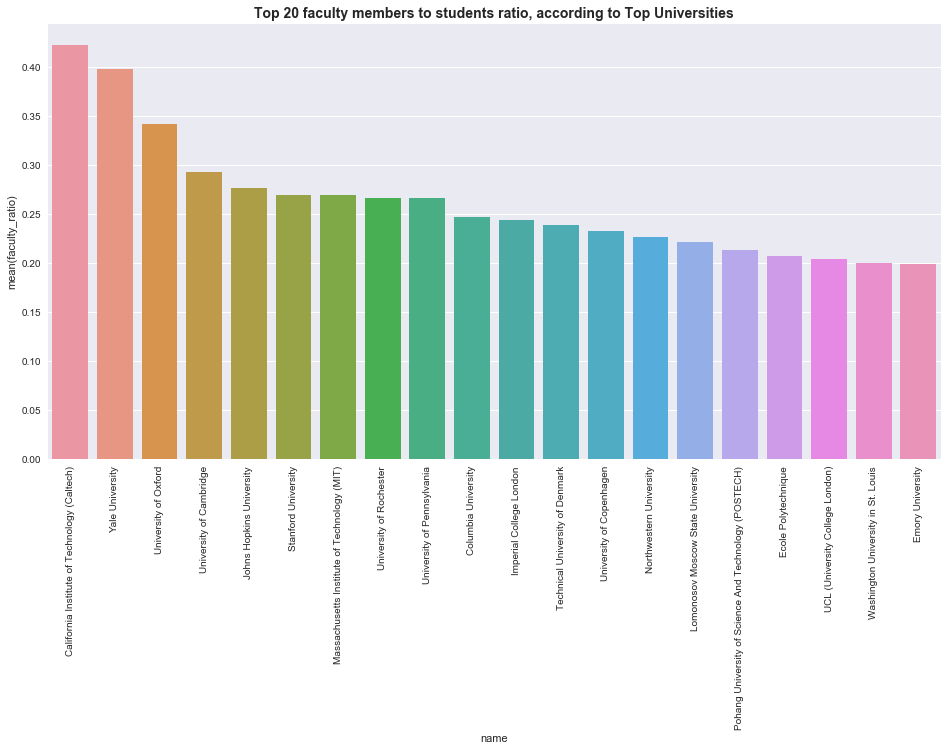

In [41]:
plot_universities_df(top_universities_faculty_ratio_df, 20, "faculty_ratio", "Top 20 faculty members to students ratio, according to Top Universities")

### 1. b) Best universities in term of international students ratio

In [42]:
top_universities_international_ratio_df = get_best_international_ratio_university(top_universities_df)
top_universities_international_ratio_df.head()

,international_ratio,name,rank,students_total,students_international,country,region
34,0.691393,London School of Economics and Political Scien...,35,9760.0,6748.0,United Kingdom,Europe
11,0.570047,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,10343.0,5896.0,Switzerland,Europe
7,0.543567,Imperial College London,8,16090.0,8746.0,United Kingdom,Europe
198,0.502533,Maastricht University,200,16385.0,8234.0,Netherlands,Europe
47,0.478062,Carnegie Mellon University,47,13356.0,6385.0,United States,North America


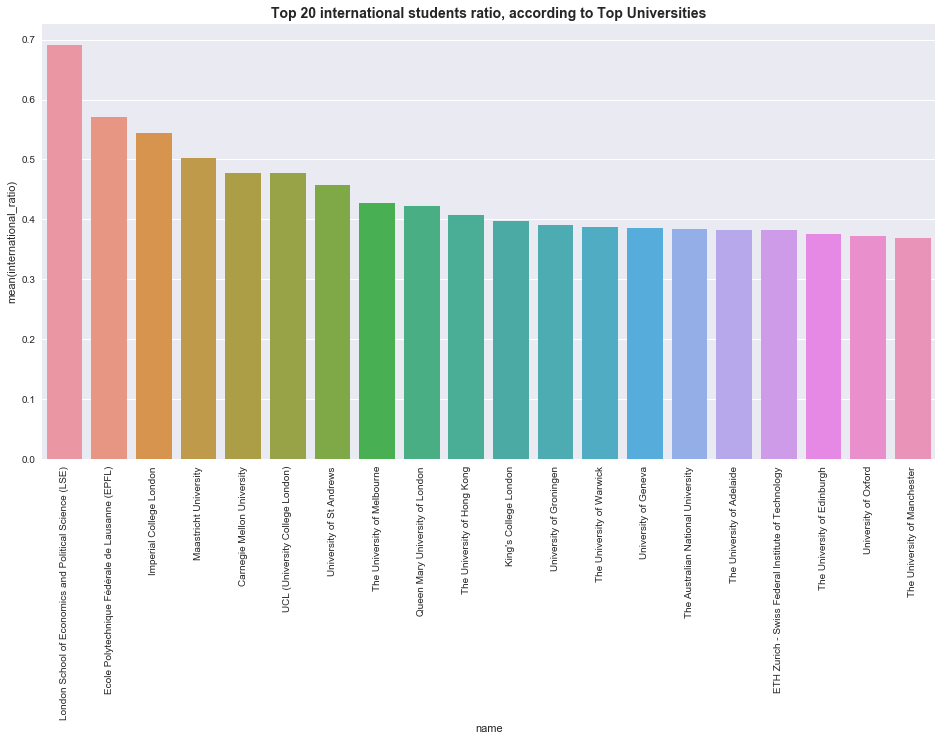

In [43]:
plot_universities_df(top_universities_international_ratio_df, 20, "international_ratio", "Top 20 international students ratio, according to Top Universities")

### 1. c) Best countries

In [44]:
top_universities_countries_df = get_countries_df(top_universities_df)

In [45]:
top_universities_countries_df

,students_total,students_international,faculty_total,faculty_ratio,faculty_ratio_inv,international_ratio
country,,,,,,
Argentina,122301.0,27109.0,16421.0,0.134267,7.447841,0.221658
Australia,301994.0,106359.0,22034.0,0.072962,13.705818,0.352189
Austria,63446.0,19667.0,4117.0,0.064890,15.410736,0.309980
Belgium,115067.0,17013.0,8046.0,0.069924,14.301143,0.147853
Brazil,92283.0,3052.0,7550.0,0.081814,12.222914,0.033072
Canada,281514.0,73239.0,29317.0,0.104140,9.602415,0.260161
Chile,27003.0,991.0,2260.0,0.083694,11.948230,0.036700
China,235898.0,26833.0,27220.0,0.115389,8.666348,0.113748
Denmark,67223.0,9543.0,11916.0,0.177261,5.641407,0.141960


### 1. c) a) Best countries in term of faculty members to students ratio

In [46]:
top_universities_countries_faculty_ratio_df = get_best_faculty_ratio_country(top_universities_countries_df)
top_universities_countries_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,students_total,faculty_total
country,,,,
Russia,0.221910,4.506335,30233.0,6709.0
Denmark,0.177261,5.641407,67223.0,11916.0
Saudi Arabia,0.175828,5.687382,6040.0,1062.0
Singapore,0.161530,6.190809,58466.0,9444.0
Malaysia,0.153893,6.498004,17902.0,2755.0


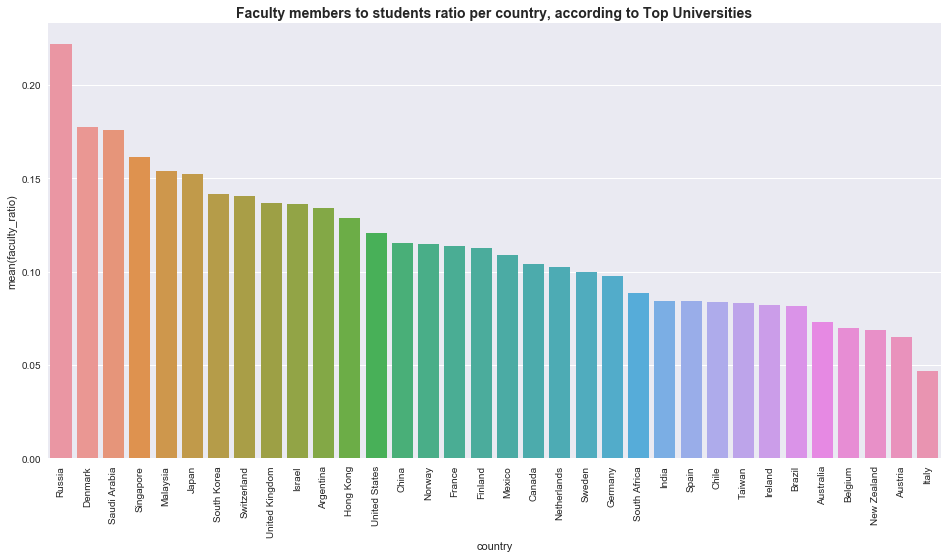

In [47]:
plot_geo_df(top_universities_countries_faculty_ratio_df, "faculty_ratio", "Faculty members to students ratio per country, according to Top Universities")

### 1. c) b) Best countries in term of international students ratio

In [48]:
top_universities_countries_international_ratio_df = get_best_international_ratio_country(top_universities_countries_df)
top_universities_countries_international_ratio_df.head()

,international_ratio,students_total,students_international
country,,,
Australia,0.352189,301994.0,106359.0
United Kingdom,0.341705,583621.0,199426.0
Hong Kong,0.310751,78838.0,24499.0
Austria,0.309980,63446.0,19667.0
Switzerland,0.302396,109112.0,32995.0


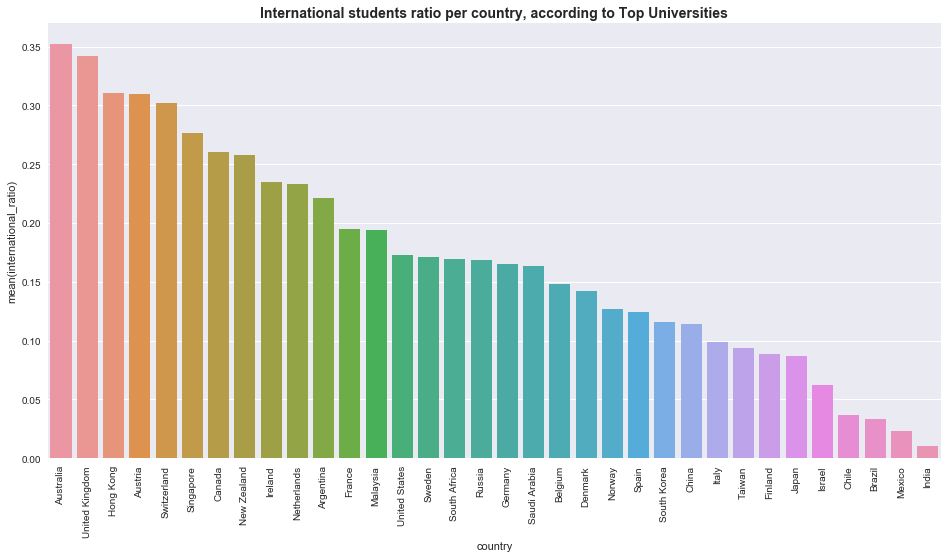

In [49]:
plot_geo_df(top_universities_countries_international_ratio_df, "international_ratio", "International students ratio per country, according to Top Universities")

### 1. d) Best regions

In [50]:
top_universities_regions_df = get_regions_df(top_universities_df)

In [51]:
top_universities_regions_df

,students_total,students_international,faculty_total,faculty_ratio,faculty_ratio_inv,international_ratio
region,,,,,,
Africa,19593.0,3325.0,1733.0,0.088450,11.305828,0.169703
Asia,807003.0,110100.0,106734.0,0.132260,7.560880,0.136431
Europe,1957251.0,449364.0,218358.0,0.111564,8.963496,0.229589
Latin America,396902.0,34737.0,43126.0,0.108657,9.203311,0.087520
North America,1546353.0,292116.0,182123.0,0.117776,8.490707,0.188906
Oceania,350167.0,118798.0,25347.0,0.072385,13.814929,0.339261


### 1. d) a) Best regions in term of faculty members to students ratio

In [52]:
top_universities_regions_faculty_ratio_df = get_best_faculty_ratio_region(top_universities_regions_df)
top_universities_regions_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,students_total,faculty_total
region,,,,
Asia,0.132260,7.560880,807003.0,106734.0
North America,0.117776,8.490707,1546353.0,182123.0
Europe,0.111564,8.963496,1957251.0,218358.0
Latin America,0.108657,9.203311,396902.0,43126.0
Africa,0.088450,11.305828,19593.0,1733.0


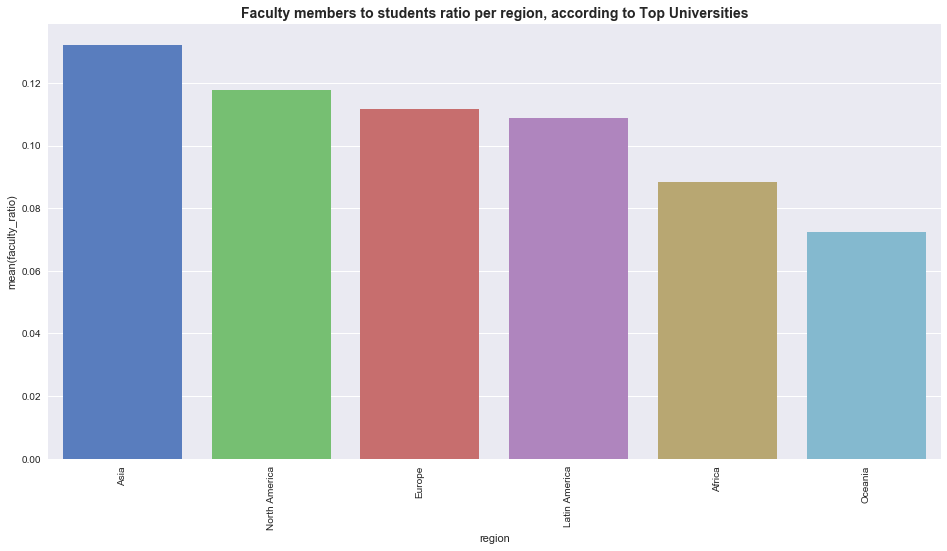

In [53]:
plot_geo_df(top_universities_regions_faculty_ratio_df, "faculty_ratio", "Faculty members to students ratio per region, according to Top Universities")

### 1. d) b) Best regions in term of international students ratio

In [54]:
top_universities_regions_international_ratio_df = get_best_international_ratio_region(top_universities_regions_df)
top_universities_regions_international_ratio_df.head()

,international_ratio,students_total,students_international
region,,,
Oceania,0.339261,350167.0,118798.0
Europe,0.229589,1957251.0,449364.0
North America,0.188906,1546353.0,292116.0
Africa,0.169703,19593.0,3325.0
Asia,0.136431,807003.0,110100.0


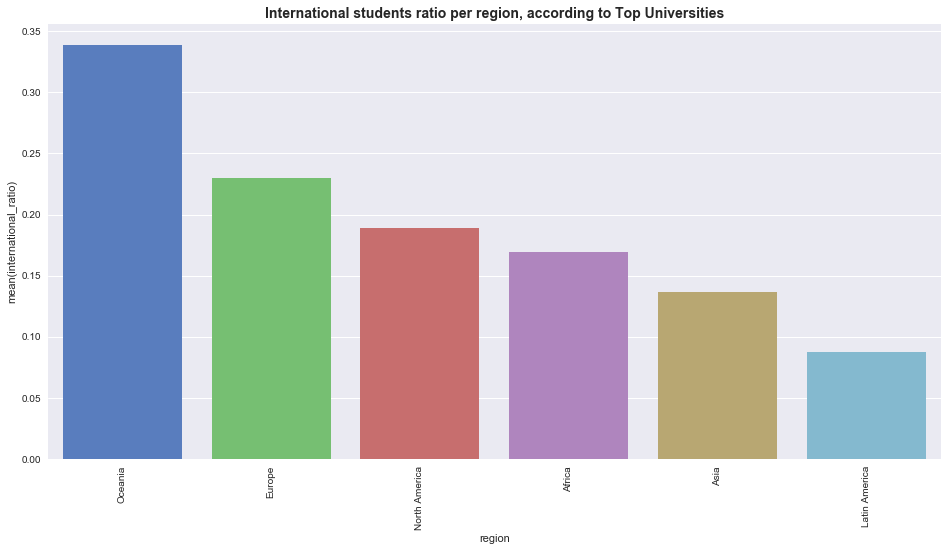

In [55]:
plot_geo_df(top_universities_regions_international_ratio_df, "international_ratio", "International students ratio per region, according to Top Universities")

### Additionnal plots

To have a better overview of the ranking we decided to plot a few representative data

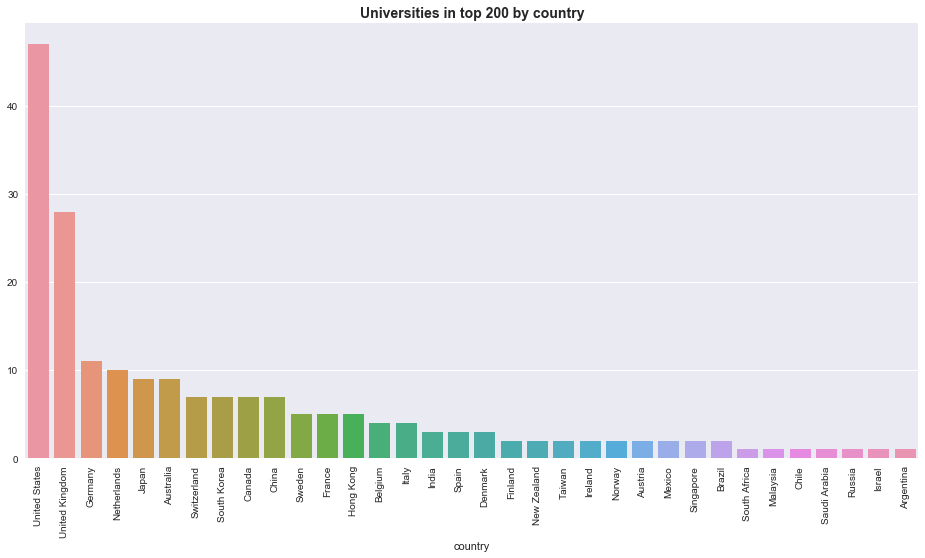

In [184]:
count_country = top_universities_df.groupby('country').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_country.index, count_country.values,ax=axes)
p.set_xticklabels(count_country.index,rotation=90)
p.set_title('Universities in top 200 by country', fontsize=14, fontweight='bold')

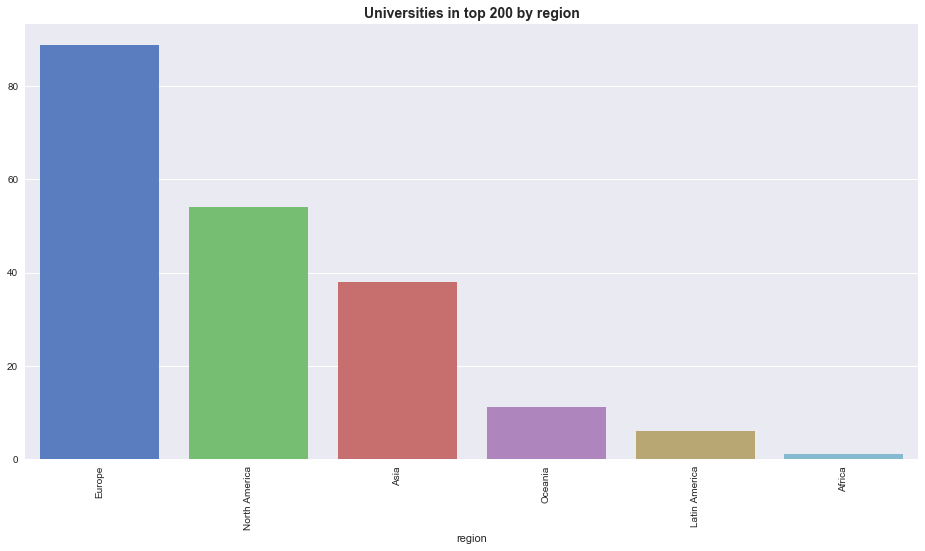

In [56]:
count_region = top_universities_df.groupby('region').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('muted')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_region.index, count_region.values,ax=axes)
p.set_xticklabels(count_region.index,rotation=90)
p.set_title('Universities in top 200 by region', fontsize=14, fontweight='bold')

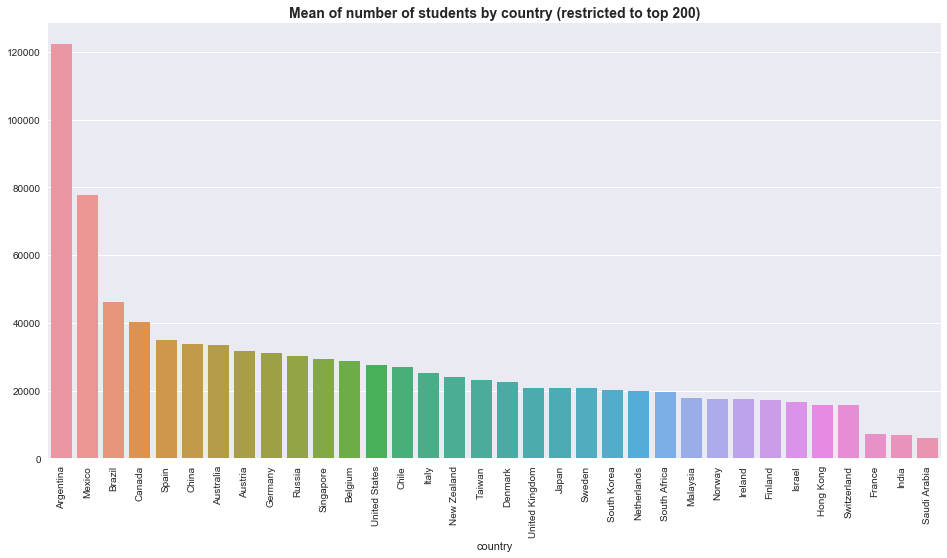

In [58]:
mean_country = top_universities_df.groupby('country').mean()['students_total'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(mean_country.index, mean_country.values,ax=axes)
p.set_xticklabels(mean_country.index,rotation=90)
p.set_title('Mean of number of students by country (restricted to top 200)', fontsize=14, fontweight='bold')

We have to be careful with the previous plot, becasue we only take into account universities in the top 200, so all countries does not have the same number of universities. For example, only one university is ranked for Argentina, therefore it is not comparable with other countries such as USA.

## 2. Times Higher Education analysis

### 2. a) Best universities in term of faculty members to students ratio

In [59]:
times_faculty_ratio_df = get_best_faculty_ratio_university(times_df)
times_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,name,rank,students_total,faculty_total,country,region
105,0.303030,3.3,Vanderbilt University,105,12011,3639.696970,United States,North America
108,0.243902,4.1,University of Copenhagen,109,30395,7413.414634,Denmark,Europe
153,0.232558,4.3,University of Rochester,153,9636,2240.930233,United States,North America
11,0.232558,4.3,Yale University,12,12155,2826.744186,United States,North America
12,0.232558,4.3,Johns Hopkins University,13,15498,3604.186047,United States,North America


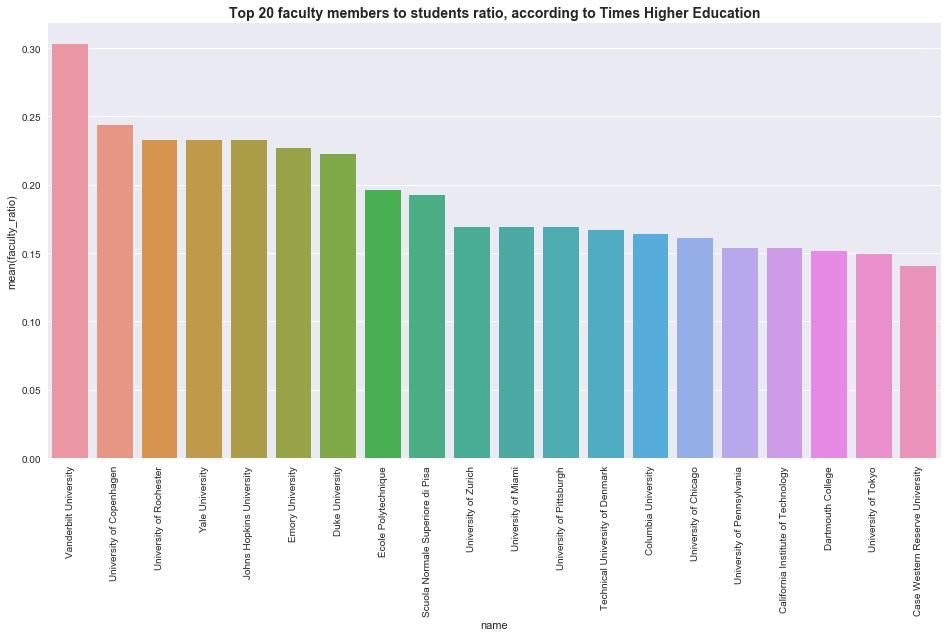

In [60]:
plot_universities_df(times_faculty_ratio_df, 20, "faculty_ratio", "Top 20 faculty members to students ratio, according to Times Higher Education")

### 2. b) Best universities in term of international students ratio

In [61]:
times_international_ratio_df = get_best_international_ratio_university(times_df)
times_international_ratio_df.head()

,international_ratio,name,rank,students_total,students_international,country,region
25,0.71,London School of Economics and Political Science,25,10065,7146.15,United Kingdom,Europe
179,0.57,University of Luxembourg,179,4969,2832.33,Luxembourg,Europe
37,0.55,École Polytechnique Fédérale de Lausanne,38,9928,5460.40,Switzerland,Europe
7,0.55,Imperial College London,8,15857,8721.35,United Kingdom,Europe
102,0.50,Maastricht University,103,16727,8363.50,Netherlands,Europe


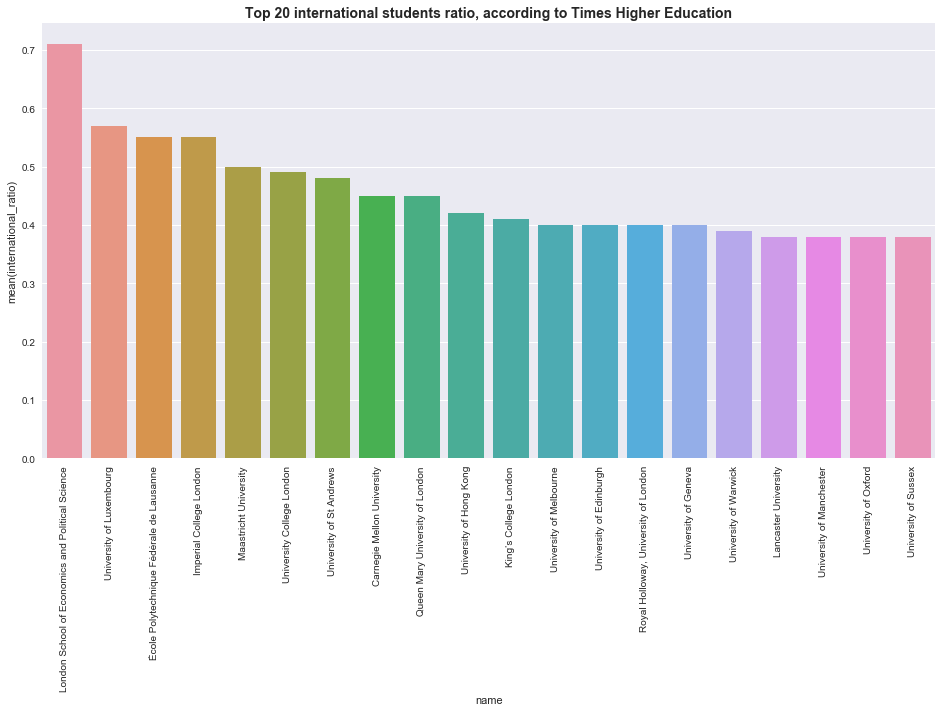

In [62]:
plot_universities_df(times_international_ratio_df, 20, "international_ratio", "Top 20 international students ratio, according to Times Higher Education")

### 2. c) Best countries

In [63]:
times_countries_df = get_countries_df(times_df)

In [64]:
times_countries_df

,students_total,students_international,faculty_total,faculty_ratio,faculty_ratio_inv,international_ratio
country,,,,,,
Australia,268630,83811.65,9940.035694,0.037003,27.025054,0.311997
Austria,35375,9197.50,1700.721154,0.048077,20.800000,0.260000
Belgium,130115,23768.44,3428.131589,0.026347,37.955077,0.182673
Canada,249401,55905.59,13239.558680,0.053085,18.837561,0.224159
China,253911,22882.57,21390.183014,0.084243,11.870445,0.090120
Denmark,64110,9326.86,10598.011371,0.165310,6.049248,0.145482
Finland,35276,3900.72,2021.755287,0.057312,17.448205,0.110577
France,99378,18975.93,7437.347864,0.074839,13.362021,0.190947
Germany,586364,87491.19,15355.707809,0.026188,38.185410,0.149210


### 2. c) a) Best countries in term of faculty members to students ratio

In [65]:
times_countries_faculty_ratio_df = get_best_faculty_ratio_country(times_countries_df)
times_countries_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,students_total,faculty_total
country,,,,
Denmark,0.165310,6.049248,64110,10598.011371
Russian Federation,0.136986,7.300000,29236,4004.931507
Japan,0.133343,7.499435,48481,6464.620003
Italy,0.131131,7.625963,1205,158.012821
Switzerland,0.093187,10.731135,107852,10050.381246


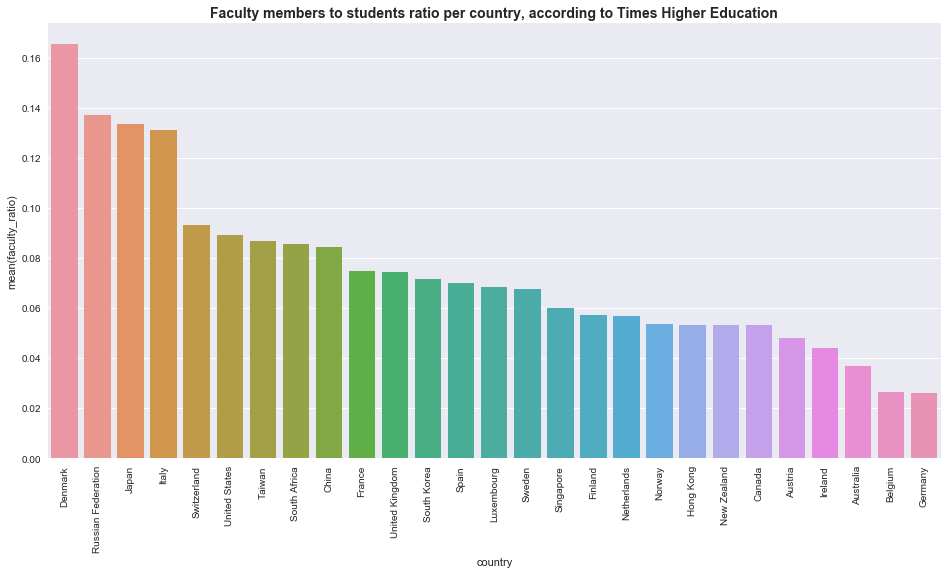

In [66]:
plot_geo_df(times_countries_faculty_ratio_df, "faculty_ratio", "Faculty members to students ratio per country, according to Times Higher Education")

### 1. c) b) Best countries in term of international students ratio

In [67]:
times_countries_international_ratio_df = get_best_international_ratio_country(times_countries_df)
times_countries_international_ratio_df.head()

,international_ratio,students_total,students_international
country,,,
Luxembourg,0.570000,4969,2832.33
United Kingdom,0.357214,596449,213059.74
Hong Kong,0.323948,77663,25158.79
Australia,0.311997,268630,83811.65
Singapore,0.304545,56101,17085.29


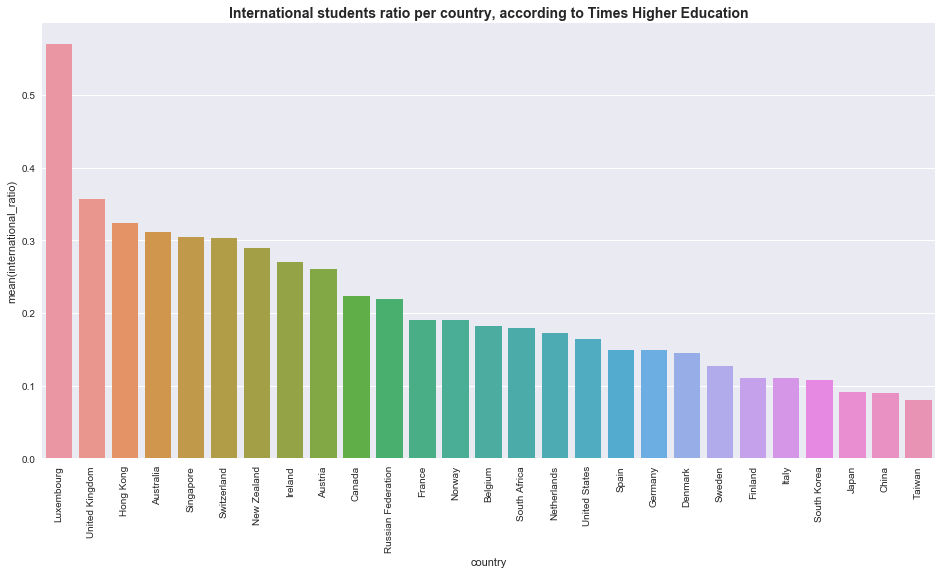

In [68]:
plot_geo_df(times_countries_international_ratio_df, "international_ratio", "International students ratio per country, according to Times Higher Education")

## 2. d) Best regions

In [69]:
times_regions_df = get_regions_df(times_df)

In [70]:
times_regions_df

,students_total,students_international,faculty_total,faculty_ratio,faculty_ratio_inv,international_ratio
region,,,,,,
Africa,20775,3739.50,1775.641026,0.085470,11.700000,0.180000
Asia,530949,78837.67,42636.062289,0.080302,12.453050,0.148484
Europe,2143623,481578.91,126864.001890,0.059182,16.897015,0.224657
North America,1954934,336270.47,165590.114089,0.084704,11.805862,0.172011
Oceania,298978,92612.57,11554.291013,0.038646,25.875928,0.309764


### 2. d) a) Best regions in term of faculty members to students ratio

In [71]:
times_regions_faculty_ratio_df = get_best_faculty_ratio_country(times_regions_df)
times_regions_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,students_total,faculty_total
region,,,,
Africa,0.085470,11.700000,20775,1775.641026
North America,0.084704,11.805862,1954934,165590.114089
Asia,0.080302,12.453050,530949,42636.062289
Europe,0.059182,16.897015,2143623,126864.001890
Oceania,0.038646,25.875928,298978,11554.291013


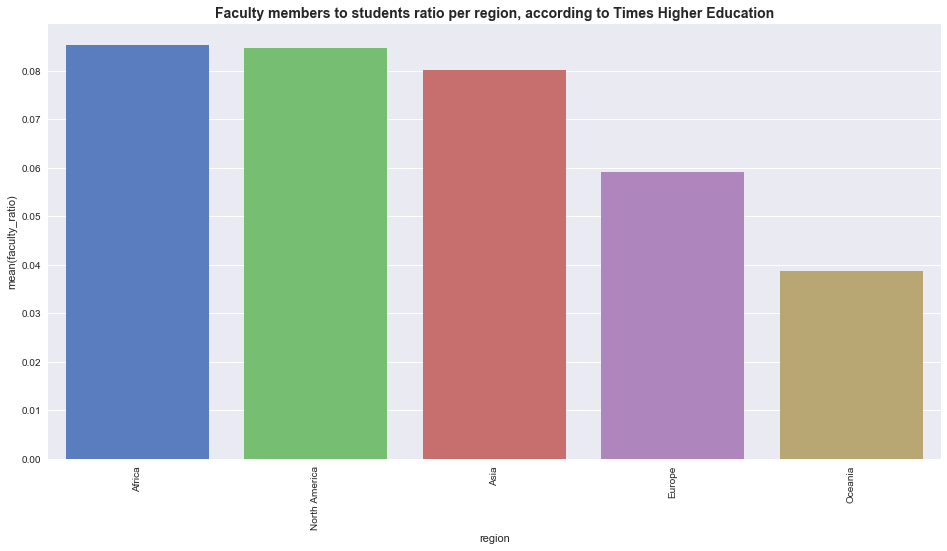

In [72]:
plot_geo_df(times_regions_faculty_ratio_df, "faculty_ratio", "Faculty members to students ratio per region, according to Times Higher Education")

### 1. d) b) Best regions in term of international students ratio

In [73]:
times_regions_international_ratio_df = get_best_international_ratio_region(times_regions_df)
times_international_ratio_df.head()

,international_ratio,name,rank,students_total,students_international,country,region
25,0.71,London School of Economics and Political Science,25,10065,7146.15,United Kingdom,Europe
179,0.57,University of Luxembourg,179,4969,2832.33,Luxembourg,Europe
37,0.55,École Polytechnique Fédérale de Lausanne,38,9928,5460.40,Switzerland,Europe
7,0.55,Imperial College London,8,15857,8721.35,United Kingdom,Europe
102,0.50,Maastricht University,103,16727,8363.50,Netherlands,Europe


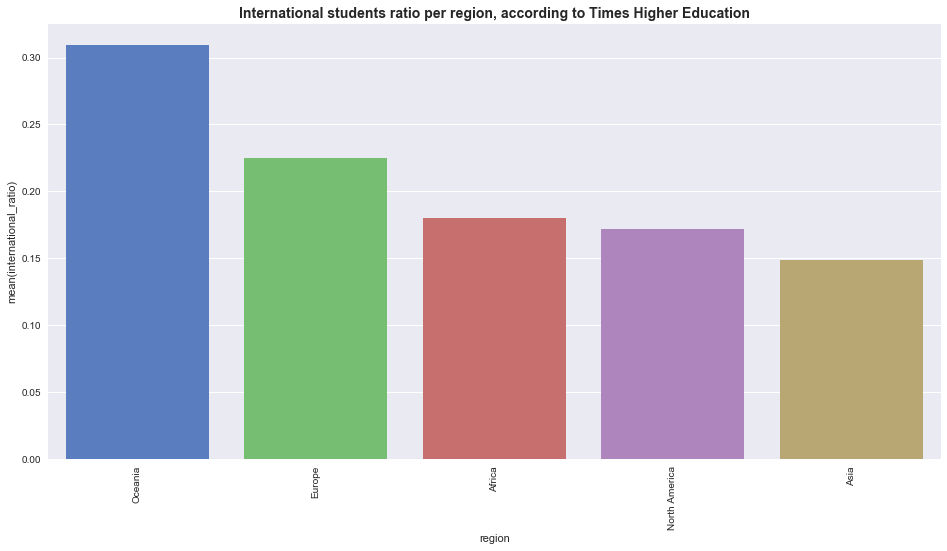

In [74]:
plot_geo_df(times_regions_international_ratio_df, "international_ratio", "International students ratio per region, according to Times Higher Education")

### Additionnal plots

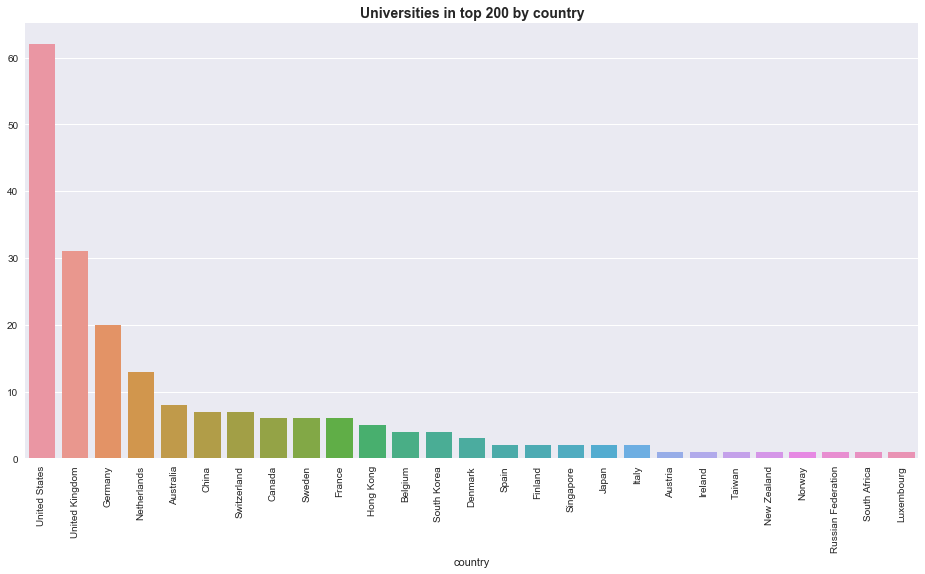

In [75]:
count_country = times_df.groupby('country').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_country.index, count_country.values,ax=axes)
p.set_xticklabels(count_country.index,rotation=90)
p.set_title('Universities in top 200 by country', fontsize=14, fontweight='bold')

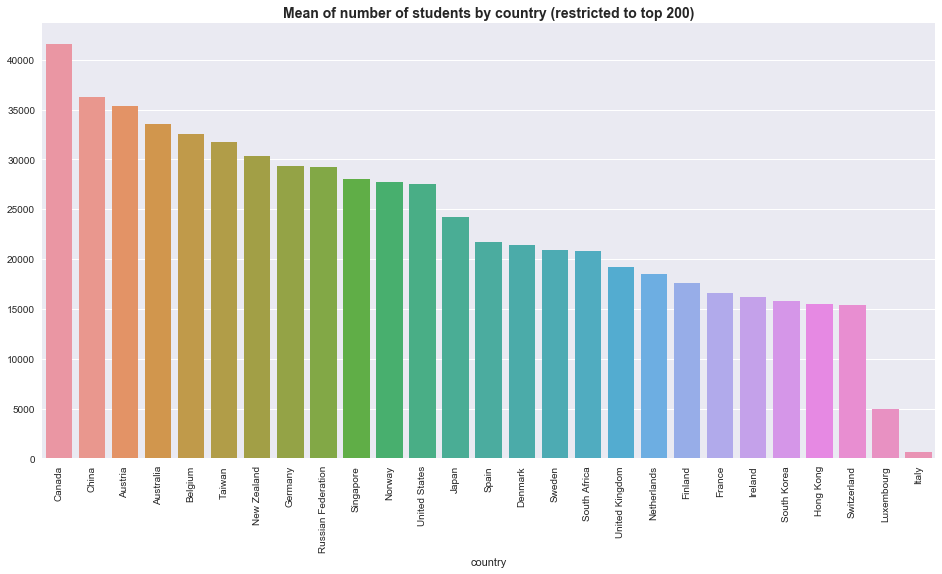

In [76]:
mean_country = times_df.groupby('country').mean()['students_total'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(mean_country.index, mean_country.values,ax=axes)
p.set_xticklabels(mean_country.index,rotation=90)
p.set_title('Mean of number of students by country (restricted to top 200)', fontsize=14, fontweight='bold')

## Question 3

First, we do a classic merge by doing a perfect match with the name of the universities, to reduce the size of the two mismatches data frames.

Then, we performed some text pre-processing on the name of those universities, by removing accents, punctuation, translating foreign words and synonyms to a common English word, and by generating a set of tokens containing words and bigrams.

Then, for each pairs of mismatching universities, we measured the distance between the two sets using this formula : $$\frac{\mathbf{card}(A \cap B)}{\mathbf{card}(A \cup B)}$$

Afterwards, we selected the best match for A in B, and vice versa, to obtain the best possible pairs, without duplicates.

Next, we plotted the distribution of similarity values, to decide on a range of thresholds, before doing some trials and errors to find the best threshold which removes incorrect pairs but keeps a maximum of good ones.

In [77]:
import string
from math import sqrt

def text_synonyms(text):
    synonyms = {
        'universiti':'university', 
        'universite':'university', 
        'universitat':'university', 
        'universitaet':'university', 
        'universidad':'university', 
        'universidade':'university', 
        'universiteit':'university',
        'king\'s':'kings'
    }
    return [word if not(word in synonyms) else synonyms[word] for word in text]

def text_bigrams(text):
    """
    Return the bigrams of the list of tokens
    """
    bigrams  = []
    for index, word in enumerate(text):
        if index + 1 < len(text):
            bigrams += [word + " " + text[index + 1]]
    return bigrams

def text_remove_accents(text):
    try:
        import unidecode
        return unidecode.unidecode(text)
    except ImportError:
        return text.translate(str.maketrans('àáâãäåçèéêëìíîïðñòóôõöøùúûüýÿšž', 'aaaaaaceeeeiiiidnoooooouuuuyysz'))

def text_preprocessing(df, columns="name", suffix="_preprocessed", stopwords=set(["le", "la", "the", "of", "de", "and", "at", "et"])):
    """
    For all selected textual columns of dataframe, 
    append a new preprocessed column which consist of a set of tokens and bigrams
    extracted from text, without any punctuations/accents/uppercases/stopwords.
    """
    data = df[[columns]]
    data = data.applymap(lambda text: text_remove_accents(text.lower().translate(str.maketrans('-–', '  ')).translate(str.maketrans('', '', string.punctuation))))
    data = data.applymap(lambda text: [token for token in text.split() if token not in stopwords])
    data = data.applymap(lambda text: text_synonyms(text))
    data = data.applymap(lambda text: set(text + text_bigrams(text)))
    data = data.add_suffix(suffix)
    return df.join(data)

def dataframe_crossjoin(A, B, suffixes=('_A', '_B')):
    """
    Return the cartesian product between the two DataFrames
    """
    A['_tmpkey'] = 1
    B['_tmpkey'] = 1

    AB = pd.merge(A, B, on='_tmpkey', suffixes=suffixes).drop('_tmpkey', axis=1)
    AB.index = pd.MultiIndex.from_product((A.index, B.index))

    A.drop('_tmpkey', axis=1, inplace=True)
    B.drop('_tmpkey', axis=1, inplace=True)

    return AB

def set_distance(A, B):
    """
    Return the distance between two sets, card(A & B) / card(A | B)
    """
    inter = A.intersection(B)
    union = A.union(B)
    return (len(inter) / len(union))

def merge_data(A , B, left_on="name", right_on="name", suffixes=('_A', '_B'), similarity=0.50):
    """
    Merge the data according to the similarity between the two sets of words
    """
    #Exact macth
    exact_matches = A.merge(B, left_on=left_on, right_on=right_on, how="inner", suffixes=suffixes)
    
    #Select doesn't match
    A_no_matches  = A[~A[left_on ].isin(exact_matches[left_on ])]
    B_no_matches  = B[~B[right_on].isin(exact_matches[right_on])]
    
    A = text_preprocessing(A_no_matches, left_on )
    B = text_preprocessing(B_no_matches, right_on)
    
    #Select amongst all possibles pairs, the best one, with a similarity at least higher than the threshold
    cross = dataframe_crossjoin(A, B, suffixes)
    
    selected_cross = cross[[left_on  + "_preprocessed" + suffixes[0], right_on + "_preprocessed" + suffixes[1]]]
    selected_cross = pd.DataFrame(selected_cross.apply(lambda x: set_distance(x[0], x[1]), axis=1))
    selected_cross = selected_cross.loc[selected_cross.groupby(level=0).idxmax()[0]]
    selected_cross = selected_cross.loc[selected_cross.groupby(level=1).idxmax()[0]]
    selected_cross = (selected_cross >= similarity)[0]
    selected_cross = selected_cross[selected_cross].index.tolist()
    
    #We select the first name as the reference
    left  = [left_on + suffixes[0]]
    right = exact_matches.columns.tolist()
    right.remove(right_on)
    fuzzy_matches = cross.loc[selected_cross][left + right].reindex()
    fuzzy_matches.columns = exact_matches.columns
    
    A_no_matches = A_no_matches[~A_no_matches.index.isin([x[0] for x in fuzzy_matches.index.values])]
    B_no_matches = B_no_matches[~B_no_matches.index.isin([x[1] for x in fuzzy_matches.index.values])]
    
    matches = exact_matches.append(fuzzy_matches)
    matches.index = [i for i in range(0, matches.shape[0])]
    
    #return cross.loc[selected_cross], A_no_matches, B_no_matches
    return matches, A_no_matches, B_no_matches
    
m, a, b = merge_data(times_df[["name", "rank"]], top_universities_df[["name", "rank"]], suffixes=('_times','_top_universities'))
m

,name,rank_times,rank_top_universities
0,University of Oxford,1,6
1,University of Cambridge,2,5
2,Stanford University,3,2
3,Harvard University,6,3
4,Princeton University,7,13
5,Imperial College London,8,8
6,University of Chicago,9,9
7,University of Pennsylvania,10,19
8,Yale University,12,16
9,Johns Hopkins University,13,17


Note: We get 152 rows because we chose to drop universities that were present in only one of the rankings.

# Part 4

We calculate all correlations between all pairs of variables before printing the distribution of values to select a good threshold in order to extract good correlations.

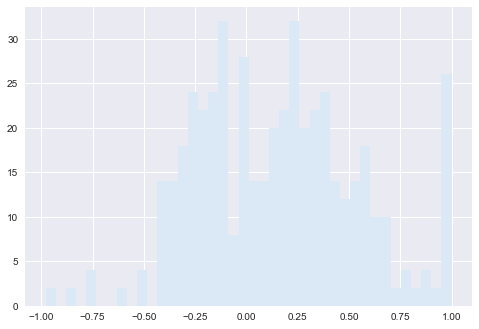

In [79]:
m, a, b = merge_data(times_df, top_universities_df, suffixes=('_times','_top_universities'))
corr = m.corr().stack()
corr.hist(bins=40)

We remove too low and too high correlations (like the total number of students in both ranking) which are not useful, and we remove duplicates.

In [80]:
selec = corr[(abs(corr) > 0.65) & (abs(corr) < 1)] #Remove below moderate and perfect relationships.
selec = selec[~pd.DataFrame(np.sort(np.array(selec.index.tolist()), 1)).duplicated().values].to_frame()
selec

0
students_total_times                 students_total_top_universities          0.979261
faculty_total_times                  faculty_total_top_universities           0.748940
students_international_times         students_international_top_universities  0.926375
overall_score_times                  rank_top_universities                   -0.747435
                                     overall_score_top_universities           0.817131
international_score_times            international_ratio_times                0.783148
                                     international_score_top_universities     0.682480
                                     international_ratio_top_universities     0.764961
faculty_ratio_times                  faculty_ratio_inv_times                 -0.736981
                                     faculty_ratio_top_universities           0.701109
international_ratio_times            international_students_score             0.661465
                                     international_ratio_top_universities     0.954209
rank_top_universities                overall_score_top_universities          -0.978571
international_faculty_score          international_score_top_universities     0.869454
international_students_score         international_score_top_universities     0.888245
                                     international_ratio_top_universities     0.701248
international_score_top_universities international_ratio_top_universities     0.662206
faculty_ratio_top_universities       faculty_ratio_inv_top_universities      -0.839140

The dataframe above displays the best correlations we found.
We see for example that the number of students/faculty matches pretty well between both rankings.
The overall score is also pretty close for both universities (`0.8`).
Even if there are some variations, it means that the scores can be a good indication because the rankings agree (still, we should remember that these values should not be taken too literally).

We can print the plots of some interesting correlations.

In [81]:
seaborn.set_palette('Blues')
def plot(x, y):
    plt.scatter(m[x], m[y])
    print("correlation : " + str(corr[x,y]))

<function __main__.plot>

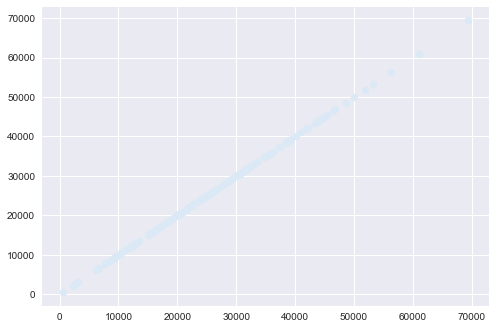

In [82]:
from ipywidgets import interact
interact(plot, x=corr.index.levels[0].tolist(), y=corr.index.levels[1].tolist())

correlation : 0.81713101208


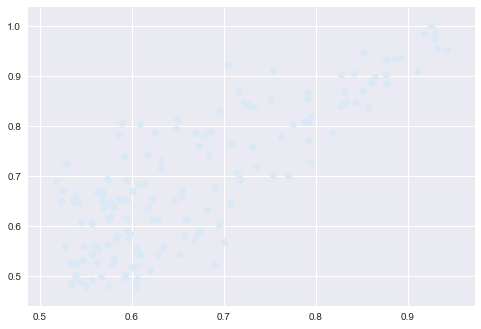

In [83]:
plot("overall_score_times", "overall_score_top_universities")

correlation : 0.783147827502


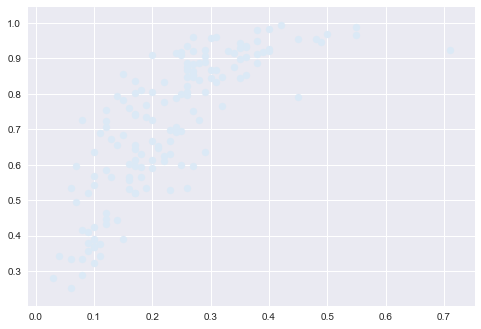

In [84]:
plot("international_ratio_times", "international_score_times")

# Part 5 


Our first idea was to use the mean of the 2 ranks to make a new feature. It is simple to do from previous rankings.


In [85]:
m, a, b = merge_data(times_df[["name", "rank","overall_score","citations_score","international_score"]], top_universities_df[["name", "rank","overall_score","citations_score","international_score"]], suffixes=('_times','_top_universities'))

In [86]:
merging_rank = m.copy()
linear_ratio_top = top_universities_df.copy()
linear_ratio_times = times_df.copy()
#Take the mean
merging_rank['mean_of_rank'] = (merging_rank['rank_times']+merging_rank['rank_top_universities'])/2
#Sort by our new column
merging_rank.sort_values(by="mean_of_rank",inplace=True)
#Reindex
merging_rank.reset_index(drop=True,inplace=True)
merging_rank[["name","mean_of_rank","rank_times","rank_top_universities"]]

,name,mean_of_rank,rank_times,rank_top_universities
0,Stanford University,2.5,3,2
1,Massachusetts Institute of Technology,3.0,5,1
2,California Institute of Technology,3.5,3,4
3,University of Oxford,3.5,1,6
4,University of Cambridge,3.5,2,5
5,Harvard University,4.5,6,3
6,Imperial College London,8.0,8,8
7,University of Chicago,9.0,9,9
8,Princeton University,10.0,7,13
9,ETH Zurich – Swiss Federal Institute of Techno...,10.0,10,10


We can see that the leader of this new ranking is neither the leader of the topuniversities nor the one from the times. 
This ranking leads us to a question, is the difference between the first and second is the same as the difference between the second and third? 
To answer this question we tried to use more precise criteria.

For example we have following scores : 
**Times** 
* overall score
* teaching
* research
* citations
* industry income
* international outlook

**top**
* academic reputation
* citations per faculty
* employer reputation
* faculty student
* international faculty
* international student

We can notice similar categories : 
The most important is overall score. 

To validate the first ranking we have to obtain a linear relation between the score and the rank

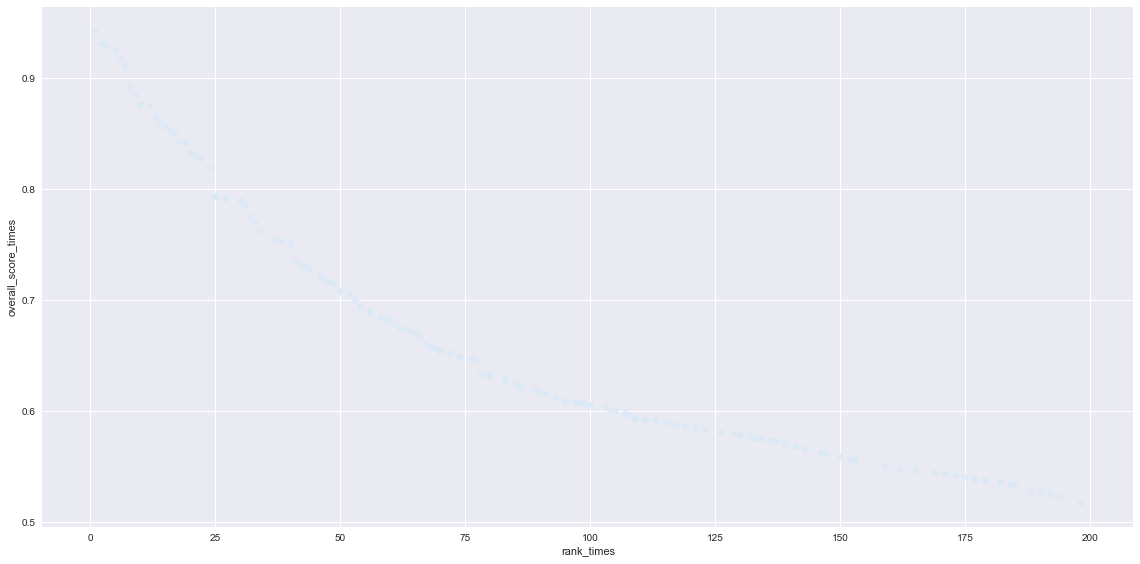

In [87]:
p = seaborn.lmplot("rank_times", "overall_score_times",data=m,fit_reg=False,size=8,aspect=2)

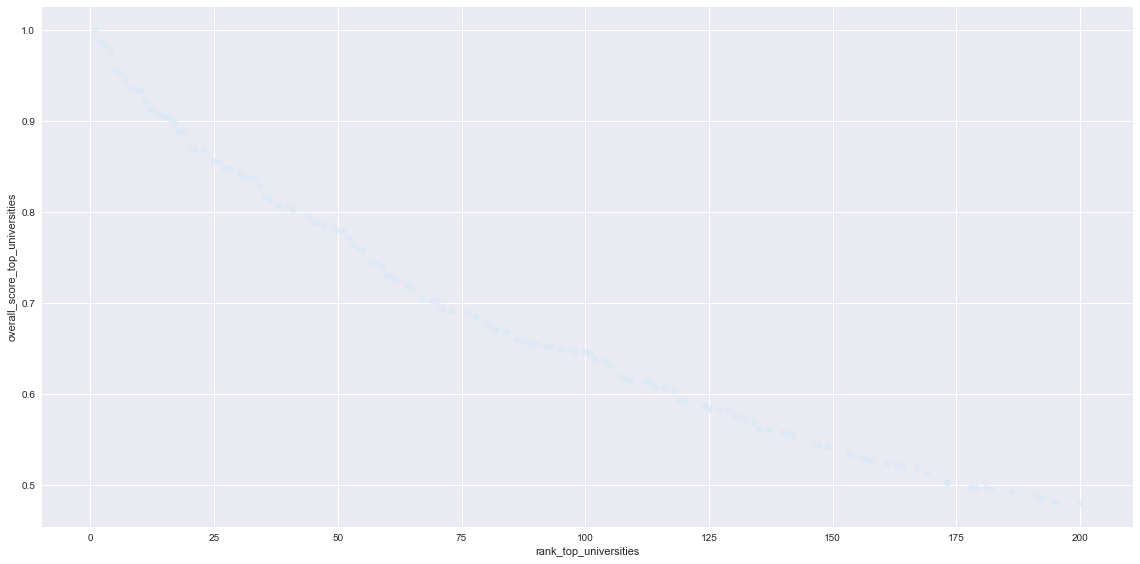

In [88]:
p = seaborn.lmplot("rank_top_universities", "overall_score_top_universities",data=m,fit_reg=False,size=8,aspect=2)

It is not too far from linear but not enough to be precise. To be sure we will plot the difference between each row and see if it is close to a constant.

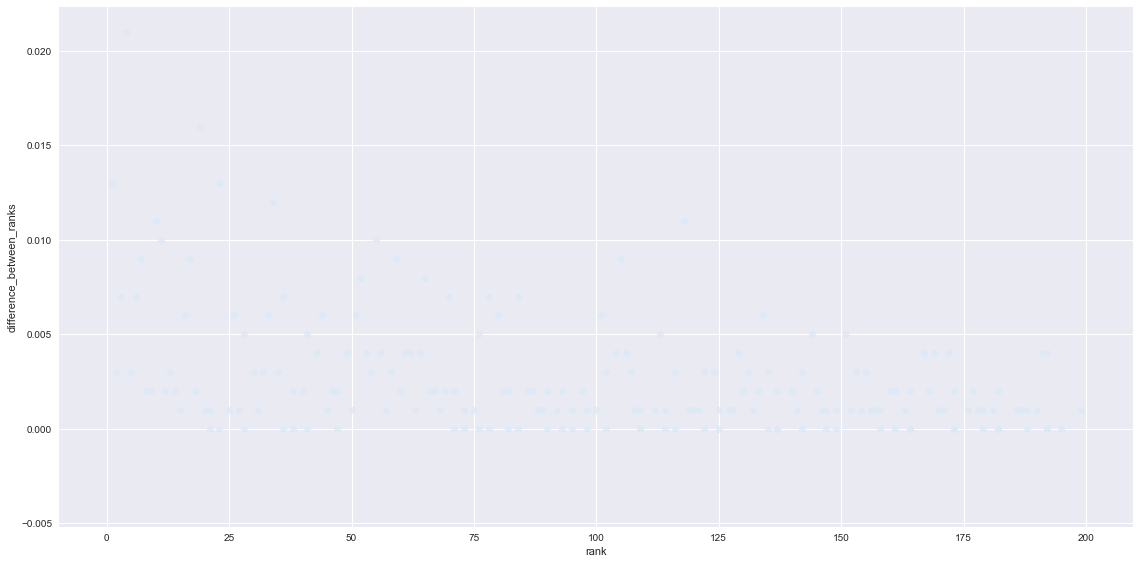

In [97]:
linear_ratio_top['difference_between_ranks'] = linear_ratio_top['overall_score'] - linear_ratio_top['overall_score'].shift(-1)
ratio_top_no_outliers=linear_ratio_top[linear_ratio_top.difference_between_ranks.le(0.05)]

p=seaborn.lmplot("rank", "difference_between_ranks",data=ratio_top_no_outliers[ratio_top_no_outliers.difference_between_ranks.ge(-0.05)],fit_reg=False,size=8,aspect=2)
#Note that there were 2 outliers, we remove them to have a better plot

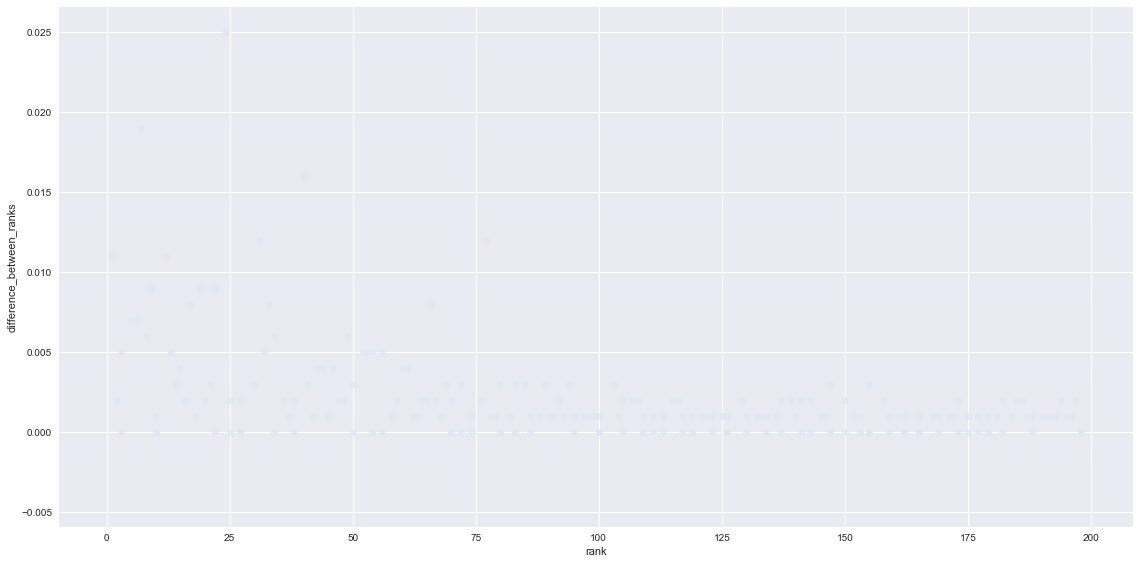

In [90]:
linear_ratio_times['difference_between_ranks'] =linear_ratio_times['overall_score'] - linear_ratio_times['overall_score'].shift(-1)
p=seaborn.lmplot("rank", "difference_between_ranks",data=linear_ratio_times,fit_reg=False,size=8,aspect=2)

We can really see that the difference fluctuates greatly, especially for top ranks.
So we will not use mean of ranks as feature to our new ranking, instead we can use the mean of overall_scores for both rankings. 
First let's normalize the data, both scores are in [0, 1] but their ranges are not the same.

In [91]:
print("Maximum score for times is : {} and minimum score in the top 200 is : {}".format(m["overall_score_times"].max(),m["overall_score_times"].min()))
print("Maximum score for top universities is : {} and minimum score in the top 200 is : {}".format(m["overall_score_top_universities"].max(),m["overall_score_top_universities"].min()))

Maximum score for times is : 0.943 and minimum score in the top 200 is : 0.517
Maximum score for top universities is : 1.0 and minimum score in the top 200 is : 0.48


We will rescale both ranking scores so that they range the whole [0, 1] scale, then we will take the mean.

In [92]:
def normalize_column(df,column_name,new_column,min_scale,max_scale):
    min_= df[column_name].min()
    df[new_column]=df[column_name]-(min_-min_scale)
    max_ = df[new_column].max()
    df[new_column]/=(max_/max_scale)

In [93]:
merging_score = m.copy()
#First normalize
normalize_column(merging_score,'overall_score_times','norm_overall_score_times', 0, 1)
normalize_column(merging_score,'overall_score_top_universities','norm_overall_score_top', 0, 1)

#Then take the mean
merging_score['mean_of_score'] = (merging_score['norm_overall_score_times']+merging_score['norm_overall_score_top'])/2
# Sort and reindex
merging_score.sort_values(by="mean_of_score",inplace=True,ascending=False)
merging_score.reset_index(drop=True,inplace=True)
merging_score[["name","mean_of_score","overall_score_times","norm_overall_score_times","overall_score_top_universities","norm_overall_score_top"]]

,name,mean_of_score,overall_score_times,norm_overall_score_times,overall_score_top_universities,norm_overall_score_top
0,Massachusetts Institute of Technology,0.978873,0.925,0.957746,1.000,1.000000
1,Stanford University,0.972242,0.930,0.969484,0.987,0.975000
2,California Institute of Technology,0.962626,0.930,0.969484,0.977,0.955769
3,Harvard University,0.955273,0.918,0.941315,0.984,0.969231
4,University of Oxford,0.954808,0.943,1.000000,0.953,0.909615
5,University of Cambridge,0.944782,0.932,0.974178,0.956,0.915385
6,Imperial College London,0.879564,0.892,0.880282,0.937,0.878846
7,Princeton University,0.875903,0.911,0.924883,0.910,0.826923
8,University of Chicago,0.870599,0.886,0.866197,0.935,0.875000
9,ETH Zurich – Swiss Federal Institute of Techno...,0.858112,0.877,0.845070,0.933,0.871154


We will now add the citations and international scores (present in both universities), we'll weigth them as follow: 

* citations 
    * times : 30% 
    * top : 20%
    * times : We examine research influence by capturing the number of times a university’s published work is cited by scholars globally.
    * Top : To calculate it, we the total number of citations received by all papers produced by an institution across a five-year period by the number of faculty members at that institution.
    * Both are normalized
* international outlook and mean of (international faculty and international student)
    * times : 7,5%
    * Top 2* 5% 
    * Times : calculated like this :
        * International-to-domestic-student ratio: 2.5%
        * International-to-domestic-staff ratio: 2.5%
        * International collaboration: 2.5%

Maybe we can use mean of overall score and take more into account citations and international outlook at it is present in both ranking 
We will use the following formula : New score = Mean(0.6\*overall_score+0.3\*citations_score+0.1\*international_score)
How did we end up with this formula ? 
We think that the overall score remains the most important factor, but to compare both scores we will just add weigth to common criteria.
We don't want to add too much importance to the criteria, so we keep overall score for 60% of the new score. Then we keep the ratio used by both times and top universities between citations and international_score.

Once again we will take normalized scores in [0, 1]

Note that we already got citations scores when building the dataFrame. We got at the same time the international outlook score for times and built the international outlook score for top universities as the mean of international faculty and international student

In [94]:
print("Maximum score for citations in times is : {} and minimum score in the top 200 is : {}".format(m["citations_score_times"].max(),m["citations_score_times"].min()))
print("Maximum score for citations in top universities is : {} and minimum score in the top 200 is : {}".format(m["citations_score_top_universities"].max(),m["citations_score_top_universities"].min()))
print("Maximum score for international outlook in times is : {} and minimum score in the top 200 is : {}".format(m["international_score_times"].max(),m["international_score_times"].min()))
print("Maximum score for international outlook in top universities is : {} and minimum score in the top 200 is : {}".format(m["international_score_top_universities"].max(),m["international_score_top_universities"].min()))

Maximum score for citations in times is : 1.0 and minimum score in the top 200 is : 0.158
Maximum score for citations in top universities is : 1.0 and minimum score in the top 200 is : 0.23399999999999999
Maximum score for international outlook in times is : 0.995 and minimum score in the top 200 is : 0.252
Maximum score for international outlook in top universities is : 1.0 and minimum score in the top 200 is : 0.1995


In [95]:
#First normalize
normalize_column(merging_score,'citations_score_times','norm_citations_score_times',0,1)
normalize_column(merging_score,'citations_score_top_universities','norm_citations_score_top',0,1)
normalize_column(merging_score,'international_score_times','norm_international_score_times',0,1)
normalize_column(merging_score,'international_score_top_universities','norm_international_score_top',0,1)
#Then create new scores
merging_score['new_score_times'] = 0.6 * merging_score['norm_overall_score_times'] + 0.3*merging_score['norm_citations_score_times']+0.1*merging_score["norm_international_score_times"]
merging_score['new_score_top_universities'] = 0.6 * merging_score['norm_overall_score_top'] + 0.3*merging_score['norm_citations_score_top']+0.1*merging_score["norm_international_score_top"]
#Take the mean 
merging_score['mean_of_new_score'] = (merging_score['new_score_times']+merging_score['new_score_top_universities'])/2
#Sort and reindex
merging_score.sort_values(by="mean_of_new_score",inplace=True,ascending=False)
merging_score.reset_index(drop=True,inplace=True)
#Finally enjoy because it's the end
merging_score[["name","mean_of_new_score","new_score_times","new_score_top_universities","overall_score_times","overall_score_top_universities"]]

,name,mean_of_new_score,new_score_times,new_score_top_universities,overall_score_times,overall_score_top_universities
0,Massachusetts Institute of Technology,0.977902,0.958632,0.997172,0.925,1.000
1,Stanford University,0.958604,0.951859,0.965348,0.930,0.987
2,Harvard University,0.950271,0.937071,0.963470,0.918,0.984
3,California Institute of Technology,0.944468,0.926342,0.962593,0.930,0.977
4,University of Oxford,0.920937,0.990737,0.851138,0.943,0.953
5,University of Cambridge,0.914017,0.966851,0.861183,0.932,0.956
6,ETH Zurich – Swiss Federal Institute of Techno...,0.900850,0.884849,0.916851,0.877,0.933
7,Princeton University,0.891531,0.925510,0.857553,0.911,0.910
8,Imperial College London,0.858616,0.912508,0.804723,0.892,0.937
9,University of Chicago,0.858474,0.877338,0.839609,0.886,0.935


With our new ranking we can notice important changes. For example, ETH moved from 9th to 4th place. 
This may seem counterintuitive because ETH is less well ranked in each of the 2 rankings. Nevertheless, our new classification highlights the similarities of previous classifications, in order to use common measures instead of separate metrics.